In [1]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from time import time
import os
# statistics
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from fbprophet import Prophet
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from pandas import DataFrame

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [2]:
train = pd.read_csv('train(2).csv',parse_dates=[2], low_memory = False)
test = pd.read_csv('test(1).csv',parse_dates=[2], low_memory = False)
store = pd.read_csv('store.csv',parse_dates=[2], low_memory = False)

In [3]:
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [4]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].max(), inplace = True)
store['CompetitionOpenSinceMonth'].fillna(int(store['CompetitionOpenSinceMonth'].mode()), inplace=True)
store['CompetitionOpenSinceYear'].fillna(int(store['CompetitionOpenSinceYear'].mode()), inplace=True)

In [5]:
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,9.0,2013.0,0,NaN,NaN,NaN
1113,1114,a,c,870.0,9.0,2013.0,0,NaN,NaN,NaN


## PREPROCESS

<AxesSubplot:title={'center':'Store1'}, xlabel='Date'>

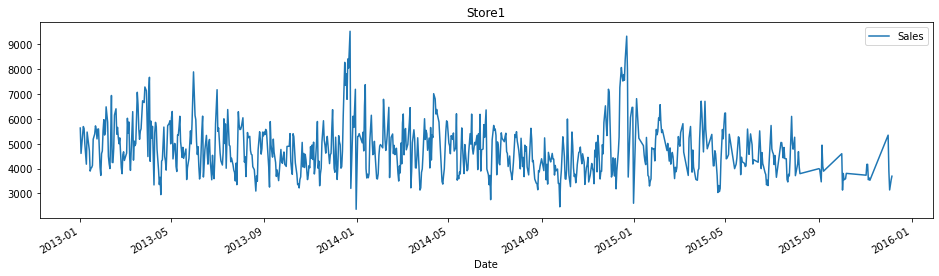

In [6]:
# sales of store1 full timne
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

In [7]:
# train[(train['Store'] == 1) & (train['Sales'] > 0)].sort_values(by='Date')

<AxesSubplot:title={'center':'Store1'}, xlabel='Date'>

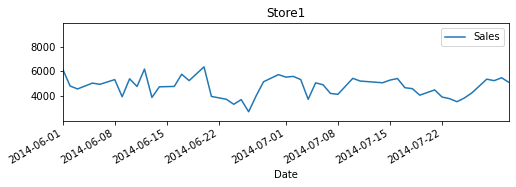

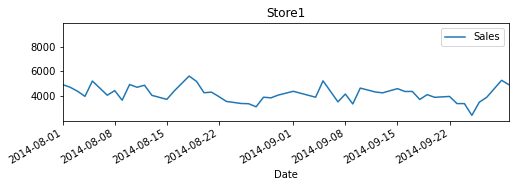

In [8]:
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-6-1','2014-7-31'])
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-8-1','2014-9-30'])

In [9]:
test.fillna(1, inplace=True)

In [10]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [11]:
store.fillna(0, inplace=True)

In [12]:
df_train_store = pd.merge(train, store, on='Store')   ## for XGBoost model
df_test_store = pd.merge(test, store, on='Store')

In [14]:
# train2['Sales/Customer'] = train2['Sales']/train2['Customers']
# train2['Sales/Customer'].describe()

# df_train_store['Sales/Customer'] = df_train_store['Sales']/df_train_store['Customers']

In [15]:
from datetime import datetime

data_types_dict = {'CompetitionOpenSinceYear': int, 'CompetitionOpenSinceMonth': int}
df_train_store = df_train_store.astype(data_types_dict)
df_test_store = df_test_store.astype(data_types_dict) 

def days_between(d1, d2):
    return abs((d2 - d1).days)

In [16]:
def has_competition(df):
    days = []
    for i in df.index:
        try:
            a = datetime.strptime(df['CompetitionOpenSinceYear'][i].astype('str')+'-'+df['CompetitionOpenSinceMonth'][i].astype('str')+'-'+'01','%Y-%m-%d').date()
            b = df['Date'][i].date()
            days.append(days_between(a, b) + 1)
        except:
            days.append(0)
    return days
    # df['HasCompetitionFor'] = days

In [17]:
#Get nearest restart month
def get_nearest_month(df):
    months = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 'Jul':'07', 'Aug':'08', 'Sept':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}
    interval = []
    for id in df.index:
        try:
            month = (df['PromoInterval'][id] or '').split(',')
            k=[]
            for item in month:
                k.append(months[item])
            interval.append(k)
        except:
            pass
            interval.append(0)
    #new = df.drop(['PromoInterval'], axis=1)
    #return new
    return interval

In [18]:
from datetime import date
from isoweek import Week

def get_startdate_promo2(df):
    startdate = []
    for ind in df.index:
        try:
            startdate.append(Week(int(df['Promo2SinceYear'][ind]), int(df['Promo2SinceWeek'][ind])).monday())
        except:
            startdate.append(0)
    # df['Promo2Since'] = startdate
    # df_new = df.drop(['Promo2SinceWeek', 'Promo2SinceYear'], axis=1)
    return startdate
    # return df

In [19]:
def get_first_date(df):
    df['PromoIntervalInNumber'] = get_nearest_month(df)
    df['Promo2Since'] = get_startdate_promo2(df)
    dates = []
    start = []
    diffs = []
    for id in df.index:
        try:
            date = []
            for item in df['PromoIntervalInNumber'][id]:
                m = item
                y = df['Year'][id].astype('str')
                DT = datetime.strptime(y+'-'+m+'-'+'01','%Y-%m-%d').date()
                date.append(DT)
            m1 = max(df['PromoIntervalInNumber'][id])
            y1 = (df['Year'][id]-1).astype('str')
            date.append(datetime.strptime(y1+'-'+m1+'-'+'01','%Y-%m-%d').date())
            date.append(df['Promo2Since'][id])
            target = df['Date'][id].date()
            res = max(dt for dt in date if dt <= target)
            diff = days_between(res, target) + 1
            diffs.append(diff)
            start.append(res)
            dates.append(date)
        except:
            diffs.append(0)
            dates.append(0)
            start.append(0)
            #traceback.print_exc()
            pass
    # df['Promo2Start'] = start
    # df['IntervalDate'] = dates
    # df['DaysSincePromo2Restarted'] = diffs
    #new = df.copy()
    df.drop(['PromoIntervalInNumber', 'Promo2Since', 'Year'], axis=1, inplace=True)
    return diffs


In [20]:
def features_create(data):
    
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    
    data['CompetitionOpen'] = has_competition(data)
    data['PromoOpen'] = get_first_date(data)
    # data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    # data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [21]:
# # iterating the columns 
# for col in df_train_store.columns: 
#     print(col) 
# for col in df_test_store.columns: 
#     print(col) 
# df_test_store['Date'].dtypes
# df_train_store['Date'].dtypes
# df_test_store['Date']= pd.to_datetime(df_test_store['Date']) 

In [22]:
features_create(df_train_store)
print('df_train_store done')
features_create(df_test_store)
print('Features creation finished')
# train.head()

df_train_store done
Features creation finished


In [22]:
# sns.set_style("whitegrid")
# sns.set_palette('magma')

# plt.figure(figsize = (20, 10))
# sns.heatmap(df_train_store.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap='bone')

In [23]:
df = df_train_store.copy()
df = df.drop(['StoreType', 'Assortment', 'CompetitionDistance'], axis=1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  int64         
 8   SchoolHoliday              1017209 non-null  int64         
 9   CompetitionOpenSinceMonth  1017209 non-null  int32         
 10  CompetitionOpenSinceYear   1017209 non-null  int32         
 11  Promo2                     1017209 no

In [25]:
categoricalCol = ['DayOfWeek', 'Day', 'Month', 'StateHoliday']

In [26]:
lst = []

for j in categoricalCol:
    a = 'dct_'+str(j)
    a = {}
    for i in df[j].unique():
        df.loc[(df[j] == i), j+'_2'] = int(df[df[j] == i].groupby(j)['Sales'].mean())
        a[i] = int(df[df[j] == i].groupby(j)['Sales'].mean())
    lst.append(a)

In [27]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth,DayOfWeek_2,Day_2,Month_2,StateHoliday_2
0,1,4,2015-07-31,5263,555,1,1,0,1,9,2008,0,0.0,0.0,,7,31,31,2525,0,Jul,0,6431.0,6235.0,6100.0,5947.0
1,1,3,2015-07-30,5020,546,1,1,0,1,9,2008,0,0.0,0.0,,7,30,31,2524,0,Jul,0,5946.0,7297.0,6100.0,5947.0
2,1,2,2015-07-29,4782,523,1,1,0,1,9,2008,0,0.0,0.0,,7,29,31,2523,0,Jul,0,6119.0,5876.0,6100.0,5947.0
3,1,1,2015-07-28,5011,560,1,1,0,1,9,2008,0,0.0,0.0,,7,28,31,2522,0,Jul,0,6973.0,5881.0,6100.0,5947.0
4,1,0,2015-07-27,6102,612,1,1,0,1,9,2008,0,0.0,0.0,,7,27,31,2521,0,Jul,0,6773.0,5801.0,6100.0,5947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,2,2013-05-01,4771,339,1,0,0,1,9,2013,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,1,18,124,62,May,0,6119.0,5463.0,5835.0,5947.0
1017205,1115,0,2013-04-01,4540,326,1,0,0,1,9,2013,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,1,14,154,32,Apr,0,6773.0,5463.0,6206.0,5947.0
1017206,1115,4,2013-03-01,4297,300,1,0,0,1,9,2013,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3,1,9,185,1,Mar,1,6431.0,5463.0,5807.0,5947.0
1017207,1115,4,2013-02-01,3697,305,1,0,0,1,9,2013,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2,1,5,213,63,Feb,0,6431.0,5463.0,6130.0,5947.0


In [28]:
for j in categoricalCol:
    for i in df[j].unique():
        df_test_store.loc[(df_test_store[j] == i), j+'_2'] = lst[categoricalCol.index(j)][i]

In [29]:
df_t = df_test_store.copy()
df_t = df_t.drop(['StoreType', 'Assortment', 'CompetitionDistance'], axis=1)

In [30]:
a = df_train_store[(df_train_store['Promo2'] == 1)  & (df_train_store['Store'] == 500)]
b = a.groupby('PromoOpen')['Sales'].mean().reset_index()
b

,PromoOpen,Sales
0,1,3928.461538
1,2,4331.615385
2,3,4221.769231
3,4,4535.769231
4,5,3374.153846
...,...,...
87,88,4438.857143
88,89,4315.285714
89,90,4840.142857
90,91,4297.200000


In [96]:
df_train_store

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,,7,31,31,2525,0,Jul,0
1,1,3,2015-07-30,5020,546,1,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,,7,30,31,2524,0,Jul,0
2,1,2,2015-07-29,4782,523,1,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,,7,29,31,2523,0,Jul,0
3,1,1,2015-07-28,5011,560,1,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,,7,28,31,2522,0,Jul,0
4,1,0,2015-07-27,6102,612,1,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,,7,27,31,2521,0,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,2,2013-05-01,4771,339,1,0,0,1,4,3,5350.0,9,2013,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,1,18,124,62,May,0
1017205,1115,0,2013-04-01,4540,326,1,0,0,1,4,3,5350.0,9,2013,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,1,14,154,32,Apr,0
1017206,1115,4,2013-03-01,4297,300,1,0,0,1,4,3,5350.0,9,2013,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3,1,9,185,1,Mar,1
1017207,1115,4,2013-02-01,3697,305,1,0,0,1,4,3,5350.0,9,2013,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2,1,5,213,63,Feb,0


<AxesSubplot:>

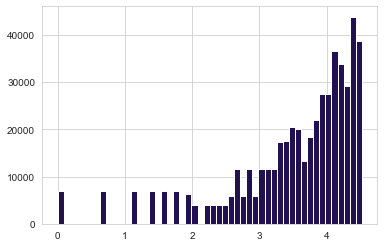

In [647]:
np.log(df_train_store[df_train_store['PromoOpen'] != 0]['PromoOpen']).hist(bins=50)

<AxesSubplot:>

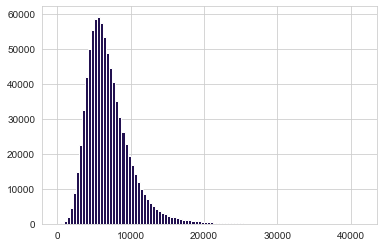

In [652]:
(df_train_store[df_train_store['Sales'] != 0]['Sales'] - df_train_store['Sales'].min()).hist(bins=100)

<AxesSubplot:>

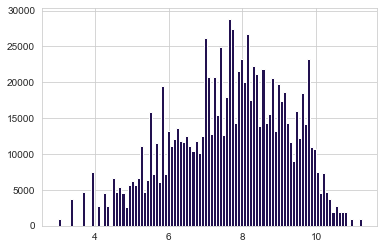

In [649]:
np.log(df_train_store[df_train_store['CompetitionDistance'] != 0]['CompetitionDistance']).hist(bins=100)

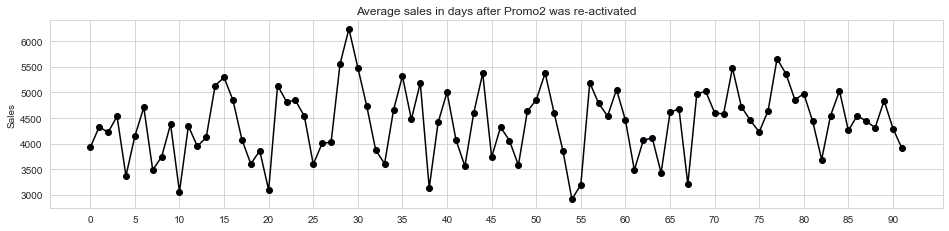

In [631]:
f = plt.figure(figsize=(16,20))

# plot average sales over time(year-month)

axis1 = f.add_subplot(511)
axis1 = b['Sales'].plot(marker='o', colormap='inferno')
axis1.set_xticks(np.arange(0, len(b), 5))
# axis1.set_xticklabels(b.index.tolist(), rotation=90)

axis1.set_title('Average sales in days after Promo2 was re-activated')
axis1.set_ylabel('Sales')
plt.show()

## FIRST

Without normalization and encoding

In [273]:
test = df[:6*7*1115]
train = df[6*7*1115:]
test = test[(test["Open"] != 0) & (test["Sales"] > 0)]
train = train[(train["Open"] != 0) & (train["Sales"] > 0)]

In [274]:
test

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth,DayOfWeek_2,Day_2,Month_2,StateHoliday_2
0,1,4,2015-07-31,5263,555,1,1,0,1,9,2008,0,0.0,0.0,,7,31,31,2525,0,Jul,0,6431.0,6235.0,6100.0,5947.0
1,1,3,2015-07-30,5020,546,1,1,0,1,9,2008,0,0.0,0.0,,7,30,31,2524,0,Jul,0,5946.0,7297.0,6100.0,5947.0
2,1,2,2015-07-29,4782,523,1,1,0,1,9,2008,0,0.0,0.0,,7,29,31,2523,0,Jul,0,6119.0,5876.0,6100.0,5947.0
3,1,1,2015-07-28,5011,560,1,1,0,1,9,2008,0,0.0,0.0,,7,28,31,2522,0,Jul,0,6973.0,5881.0,6100.0,5947.0
4,1,0,2015-07-27,6102,612,1,1,0,1,9,2008,0,0.0,0.0,,7,27,31,2521,0,Jul,0,6773.0,5801.0,6100.0,5947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46824,52,0,2014-05-19,7452,488,1,1,0,0,4,2014,1,39.0,2010.0,"Jan,Apr,Jul,Oct",5,19,21,49,49,May,0,6773.0,5826.0,5835.0,5947.0
46826,52,5,2014-05-17,6261,480,1,0,0,0,4,2014,1,39.0,2010.0,"Jan,Apr,Jul,Oct",5,17,20,47,47,May,0,5649.0,6124.0,5835.0,5947.0
46827,52,4,2014-05-16,4698,365,1,0,0,0,4,2014,1,39.0,2010.0,"Jan,Apr,Jul,Oct",5,16,20,46,46,May,0,6431.0,6378.0,5835.0,5947.0
46828,52,3,2014-05-15,5188,414,1,0,0,0,4,2014,1,39.0,2010.0,"Jan,Apr,Jul,Oct",5,15,20,45,45,May,0,5946.0,5831.0,5835.0,5947.0


In [275]:
train.drop(['Date','Open','PromoInterval','monthStr', 'Customers'],axis=1,inplace =True)
test.drop(['Date','Open','PromoInterval','monthStr', 'Customers'],axis=1,inplace =True)
xtest =df_t.drop(['Date','Open','PromoInterval','monthStr', 'Customers'],axis = 1)

x_train = train.drop(['Sales'],axis=1 )
y_train = np.log1p(train.Sales)
x_test = test.drop(['Sales'],axis=1 )
y_test = np.log1p(test.Sales)

In [89]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [277]:
dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_test, y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

params = {"objective": "reg:linear", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "silent": 1,              #verbosity
          "seed": 10                
          }
num_boost_round = 500


print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))


print("validating")
x_test.sort_index(inplace=True) 
y_test.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(x_test))
error = rmspe(np.expm1(y_test), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[15:38:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:8.02267	train-rmspe:0.99981	eval-rmse:7.98919	eval-rmspe:0.99981
[1]	train-rmse:7.78253	train-rmspe:0.99971	eval-rmse:7.74865	eval-rmspe:0.99971
[2]	train-rmse:7.54961	train-rmspe:0.99959	eval-rmse:7.51583	eval-rmspe:0.99958
[3]	train-rmse:7.32365	train-rmspe:0.99944	eval-rmse:7.29005	eval-rmspe:0.99944
[4]	train-rmse:7.10448	train-rmspe:0.99926	eval-rmse:7.07026	eval-rmspe:0.99926
[5]	train-rmse:6.89200	train-rmspe:0.99905	eval-rmse:6.85697	eval-rmspe:0.99904
[6]	train-rmse:6.68582	train-rmspe:0.99880	eval-rmse:6.65000	eval-rmspe

In [66]:
res = pd.DataFrame(data = y_test)
res['Prediction']=yhat
res = pd.merge(x_test,res, left_index= True, right_index=True)
a =  np.expm1(res['Prediction'])
b = [ round(a1, 2) for a1 in a ]
res['SalesPrediction'] = b
res['ActualSales'] = test['Sales']
res

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,SalesPrediction,ActualSales
0,1,4,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,7,31,31,2525,0,0,8.568646,8.769710,6435.30,5263
1,1,3,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,7,30,31,2524,0,0,8.521384,8.711416,6070.84,5020
2,1,2,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,7,29,31,2523,0,0,8.472823,8.684045,5906.90,4782
3,1,1,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,7,28,31,2522,0,0,8.519590,8.756958,6353.75,5011
4,1,0,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,7,27,31,2521,0,0,8.716536,8.852897,6993.62,6102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46824,52,0,1,0,0,4,3,450.0,4,2014,1,39.0,2010.0,5,19,21,49,49,0,8.916372,8.932011,7569.47,7452
46826,52,5,0,0,0,4,3,450.0,4,2014,1,39.0,2010.0,5,17,20,47,47,0,8.742255,8.609480,5482.40,6261
46827,52,4,0,0,0,4,3,450.0,4,2014,1,39.0,2010.0,5,16,20,46,46,0,8.455105,8.613055,5502.04,4698
46828,52,3,0,0,0,4,3,450.0,4,2014,1,39.0,2010.0,5,15,20,45,45,0,8.554296,8.535484,5091.30,5188


weight correction
RMSPE for 0.990:0.307799
RMSPE for 0.991:0.306160
RMSPE for 0.992:0.304691
RMSPE for 0.993:0.303400
RMSPE for 0.994:0.302295
RMSPE for 0.995:0.301383
RMSPE for 0.996:0.300671
RMSPE for 0.997:0.300166
RMSPE for 0.998:0.299874
RMSPE for 0.999:0.299801
RMSPE for 1.000:0.299955
RMSPE for 1.001:0.300339
RMSPE for 1.002:0.300959
RMSPE for 1.003:0.301820
RMSPE for 1.004:0.302926
RMSPE for 1.005:0.304280
RMSPE for 1.006:0.305886
RMSPE for 1.007:0.307746
RMSPE for 1.008:0.309862
RMSPE for 1.009:0.312235
Best weight for Score:0.999    0.299801
dtype: float64


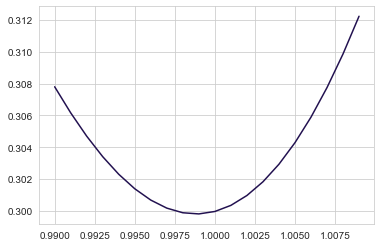

In [67]:
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(y_test), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [68]:
col_1 = ['Sales','Prediction']

# correction by store
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [69]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(y_test), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.255621


In [70]:
y_pred = [round(a1, 2) for a1 in np.expm1(yhat_new)]
res['NewPrediction'] = y_pred
res.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,SalesPrediction,ActualSales,NewPrediction
0,1,4,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,7,31,31,2525,0,0,8.568646,8.769710,6435.30,5263,5894.90
1,1,3,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,7,30,31,2524,0,0,8.521384,8.711416,6070.84,5020,5564.28
2,1,2,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,7,29,31,2523,0,0,8.472823,8.684045,5906.90,4782,5415.50
3,1,1,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,7,28,31,2522,0,0,8.519590,8.756958,6353.75,5011,5820.94
4,1,0,1,0,1,3,1,1270.0,9,2008,0,0.0,0.0,7,27,31,2521,0,0,8.716536,8.852897,6993.62,6102,6401.01


In [72]:
xtest = xtest.drop(['Sales'], axis=1)

In [73]:
y_fin = gbm.predict(xgb.DMatrix(xtest))
xtest['PredictedSales'] = [round(n, 0) for n in np.expm1(y_fin)]
xtest

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,PredictedSales
0,1,3,1,0,0,3,1,1270.0,9,2008,0,0.0,0.0,9,17,38,2573,0,0,5560.0
1,1,2,1,0,0,3,1,1270.0,9,2008,0,0.0,0.0,9,16,38,2572,0,0,5615.0
2,1,1,1,0,0,3,1,1270.0,9,2008,0,0.0,0.0,9,15,38,2571,0,0,6085.0
3,1,0,1,0,0,3,1,1270.0,9,2008,0,0.0,0.0,9,14,38,2570,0,0,6865.0
4,1,6,0,0,0,3,1,1270.0,9,2008,0,0.0,0.0,9,13,37,2569,0,0,4679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1115,4,1,0,1,4,3,5350.0,0,0,1,22.0,2012.0,5,8,19,0,69,0,5634.0
41084,1115,2,1,0,1,4,3,5350.0,0,0,1,22.0,2012.0,4,8,15,0,39,0,5621.0
41085,1115,6,1,0,1,4,3,5350.0,0,0,1,22.0,2012.0,3,8,10,0,8,1,5660.0
41086,1115,6,0,0,1,4,3,5350.0,0,0,1,22.0,2012.0,2,8,6,0,70,0,4506.0


## SECOND

Some features, filtered by variance

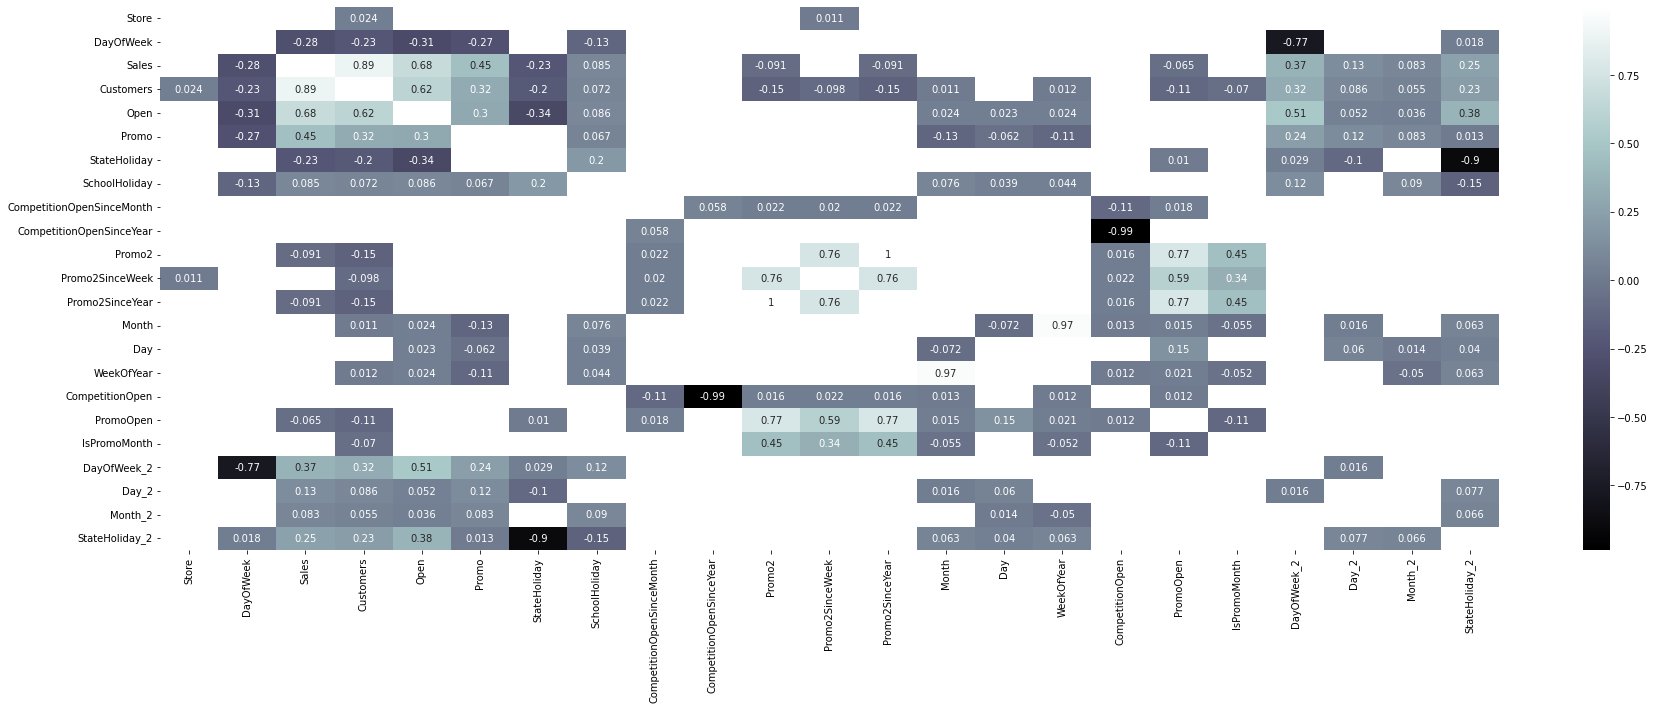

In [196]:
dfCorr = df.corr()
filteredDf = dfCorr[((dfCorr >= .01) | (dfCorr <= -.05)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="bone")
plt.show()

In [99]:
df_train_store2 = df.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'Promo2SinceWeek', 'IsPromoMonth'], axis=1)
df_train_store2

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Promo2,Promo2SinceYear,PromoInterval,PromoOpen,monthStr,DayOfWeek_2,Day_2,Month_2,StateHoliday_2
0,1,4,2015-07-31,5263,555,1,1,0,1,0,0.0,,0,Jul,6431.0,6235.0,6100.0,5947.0
1,1,3,2015-07-30,5020,546,1,1,0,1,0,0.0,,0,Jul,5946.0,7297.0,6100.0,5947.0
2,1,2,2015-07-29,4782,523,1,1,0,1,0,0.0,,0,Jul,6119.0,5876.0,6100.0,5947.0
3,1,1,2015-07-28,5011,560,1,1,0,1,0,0.0,,0,Jul,6973.0,5881.0,6100.0,5947.0
4,1,0,2015-07-27,6102,612,1,1,0,1,0,0.0,,0,Jul,6773.0,5801.0,6100.0,5947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,2,2013-05-01,4771,339,1,0,0,1,1,2012.0,"Mar,Jun,Sept,Dec",62,May,6119.0,5463.0,5835.0,5947.0
1017205,1115,0,2013-04-01,4540,326,1,0,0,1,1,2012.0,"Mar,Jun,Sept,Dec",32,Apr,6773.0,5463.0,6206.0,5947.0
1017206,1115,4,2013-03-01,4297,300,1,0,0,1,1,2012.0,"Mar,Jun,Sept,Dec",1,Mar,6431.0,5463.0,5807.0,5947.0
1017207,1115,4,2013-02-01,3697,305,1,0,0,1,1,2012.0,"Mar,Jun,Sept,Dec",63,Feb,6431.0,5463.0,6130.0,5947.0


In [100]:
test2 = df_train_store2[:6*7*1115]
train2 = df_train_store2[6*7*1115:]
test2 = test2[(test2["Open"] != 0) & (test2["Sales"] > 0)]
# test = test[test["Sales"] > 0]
train2 = train2[(train2["Open"] != 0) & (train2["Sales"] > 0)]
# train = train[train["Sales"] > 0]


train2.drop(['Date','Open','PromoInterval','monthStr', 'Customers'],axis=1,inplace =True)
test2.drop(['Date','Open','PromoInterval','monthStr', 'Customers'],axis=1,inplace =True)

x_train2 = train2.drop(['Sales'],axis=1 )
y_train2 = np.log1p(train2.Sales)
x_test2 = test2.drop(['Sales'],axis=1 )
y_test2 = np.log1p(test2.Sales)

In [103]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [104]:
dtrain2 = xgb.DMatrix(x_train2, y_train2)
dvalid2 = xgb.DMatrix(x_test2, y_test2)
watchlist2 = [(dtrain2, 'train'), (dvalid2, 'eval')]

params2 = {"objective": "reg:linear", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "silent": 1,              #verbosity
          "seed": 10                
          }
num_boost_round = 500


print("Train a XGBoost model")
start = time()
gbm = xgb.train(params2, dtrain2, num_boost_round, evals=watchlist2, 
  early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))


print("validating")
x_test2.sort_index(inplace=True) 
y_test2.sort_index(inplace=True) 
yhat2 = gbm.predict(xgb.DMatrix(x_test2))
error2 = rmspe(np.expm1(y_test2), np.expm1(yhat2))

print('RMSPE: {:.6f}'.format(error2))

Train a XGBoost model
[17:25:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:8.02272	train-rmspe:0.99981	eval-rmse:7.98947	eval-rmspe:0.99981
[1]	train-rmse:7.78260	train-rmspe:0.99971	eval-rmse:7.74923	eval-rmspe:0.99971
[2]	train-rmse:7.54969	train-rmspe:0.99959	eval-rmse:7.51866	eval-rmspe:0.99959
[3]	train-rmse:7.32378	train-rmspe:0.99944	eval-rmse:7.29264	eval-rmspe:0.99944
[4]	train-rmse:7.10464	train-rmspe:0.99926	eval-rmse:7.07574	eval-rmspe:0.99926
[5]	train-rmse:6.89220	train-rmspe:0.99905	eval-rmse:6.86331	eval-rmspe:0.99904
[6]	train-rmse:6.68608	train-rmspe:0.99879	eval-rmse:6.65707	eval-rmspe

In [105]:
res2 = pd.DataFrame(data = y_test2)
res2['Prediction']=yhat2
res2 = pd.merge(x_test2,res2, left_index= True, right_index=True)
a =  np.expm1(res2['Prediction'])
b = [ round(a1, 2) for a1 in a ]
res2['SalesPrediction'] = b
res2['ActualSales'] = test2['Sales']
res2

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Promo2,Promo2SinceYear,PromoOpen,DayOfWeek_2,Day_2,Month_2,StateHoliday_2,Sales,Prediction,SalesPrediction,ActualSales
0,1,4,1,0,1,0,0.0,0,6431.0,6235.0,6100.0,5947.0,8.568646,8.806595,6677.14,5263
1,1,3,1,0,1,0,0.0,0,5946.0,7297.0,6100.0,5947.0,8.521384,8.794493,6596.81,5020
2,1,2,1,0,1,0,0.0,0,6119.0,5876.0,6100.0,5947.0,8.472823,8.744123,6272.71,4782
3,1,1,1,0,1,0,0.0,0,6973.0,5881.0,6100.0,5947.0,8.519590,8.764028,6398.84,5011
4,1,0,1,0,1,0,0.0,0,6773.0,5801.0,6100.0,5947.0,8.716536,8.961123,7793.11,6102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46824,52,0,1,0,0,1,2010.0,49,6773.0,5826.0,5835.0,5947.0,8.916372,8.904954,7367.39,7452
46826,52,5,0,0,0,1,2010.0,47,5649.0,6124.0,5835.0,5947.0,8.742255,8.422244,4546.10,6261
46827,52,4,0,0,0,1,2010.0,46,6431.0,6378.0,5835.0,5947.0,8.455105,8.513918,4982.65,4698
46828,52,3,0,0,0,1,2010.0,45,5946.0,5831.0,5835.0,5947.0,8.554296,8.445022,4650.86,5188


weight correction
RMSPE for 0.990:0.324837
RMSPE for 0.991:0.323270
RMSPE for 0.992:0.321861
RMSPE for 0.993:0.320619
RMSPE for 0.994:0.319548
RMSPE for 0.995:0.318656
RMSPE for 0.996:0.317949
RMSPE for 0.997:0.317433
RMSPE for 0.998:0.317114
RMSPE for 0.999:0.316999
RMSPE for 1.000:0.317092
RMSPE for 1.001:0.317399
RMSPE for 1.002:0.317924
RMSPE for 1.003:0.318674
RMSPE for 1.004:0.319650
RMSPE for 1.005:0.320858
RMSPE for 1.006:0.322300
RMSPE for 1.007:0.323980
RMSPE for 1.008:0.325900
RMSPE for 1.009:0.328061
Best weight for Score:0.999    0.316999
dtype: float64


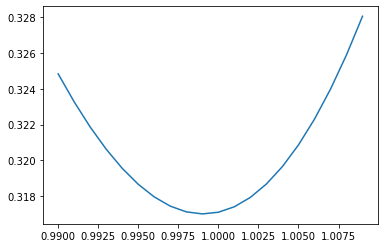

In [106]:
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(y_test2), np.expm1(yhat2*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [110]:
col_1 = ['Sales','Prediction']

# correction by store
L=range(1115)
W_ho2=[]
W_test2=[]
for i in L:
    s1 = pd.DataFrame(res2[res2['Store']==i+1],columns = col_1)
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    W_ho2.extend(b_ho.tolist())


In [111]:
yhat_new2 = yhat2*W_ho2
error2 = rmspe(np.expm1(y_test2), np.expm1(yhat_new2))
print ('RMSPE for weight corretion {:6f}'.format(error2))

y_pred2 = [round(a1, 2) for a1 in np.expm1(yhat_new2)]
res2['NewPrediction'] = y_pred2
res2.head()

RMSPE for weight corretion 0.272526


,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Promo2,Promo2SinceYear,PromoOpen,DayOfWeek_2,Day_2,Month_2,StateHoliday_2,Sales,Prediction,SalesPrediction,ActualSales,NewPrediction
0,1,4,1,0,1,0,0.0,0,6431.0,6235.0,6100.0,5947.0,8.568646,8.806595,6677.14,5263,6114.18
1,1,3,1,0,1,0,0.0,0,5946.0,7297.0,6100.0,5947.0,8.521384,8.794493,6596.81,5020,6041.35
2,1,2,1,0,1,0,0.0,0,6119.0,5876.0,6100.0,5947.0,8.472823,8.744123,6272.71,4782,5747.43
3,1,1,1,0,1,0,0.0,0,6973.0,5881.0,6100.0,5947.0,8.519590,8.764028,6398.84,5011,5861.83
4,1,0,1,0,1,0,0.0,0,6773.0,5801.0,6100.0,5947.0,8.716536,8.961123,7793.11,6102,7125.05


In [86]:
xtest2 = df_test_store.drop(['Date','Open','PromoInterval','monthStr', 'Customers'],axis = 1)

xtest2 = xtest2.drop(['Sales', 'CompetitionOpenSinceYear', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'StoreType', 'Promo2SinceWeek', 'IsPromoMonth'], axis=1)

In [87]:
y_fin2 = gbm.predict(xgb.DMatrix(xtest2))
xtest2['PredictedSales'] = [int(round(n, 0)) for n in np.expm1(y_fin2)]
xtest2

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Assortment,Promo2,Promo2SinceYear,PromoOpen,PredictedSales
0,1,3,1,0,0,1,0,0.0,0,5785
1,1,2,1,0,0,1,0,0.0,0,5830
2,1,1,1,0,0,1,0,0.0,0,6143
3,1,0,1,0,0,1,0,0.0,0,6734
4,1,6,0,0,0,1,0,0.0,0,4049
...,...,...,...,...,...,...,...,...,...,...
41083,1115,4,1,0,1,3,1,2012.0,69,6225
41084,1115,2,1,0,1,3,1,2012.0,39,6392
41085,1115,6,1,0,1,3,1,2012.0,8,6550
41086,1115,6,0,0,1,3,1,2012.0,70,5007


In [88]:
from sklearn.metrics import mean_squared_error
from math import sqrt

error_rmse = sqrt(mean_squared_error(np.expm1(y_test2), np.expm1(yhat_new2))) 
print ('RMSE for weight corretion {:6f}'.format(error_rmse))
print ('RMSPE for weight corretion {:6f}'.format(rmspe(np.expm1(y_test2), np.expm1(yhat_new2))))

RMSE for weight corretion 2093.591703
RMSPE for weight corretion 0.256182


## THIRD

With normalization and encoding

In [260]:
train_store = df_train_store.copy()
test_store = df_test_store.copy()

In [261]:
train_store.columns, test_store.columns

(Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval', 'Month', 'Day', 'WeekOfYear',
        'CompetitionOpen', 'PromoOpen', 'monthStr', 'IsPromoMonth'],
       dtype='object'),
 Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval', 'Month', 'Day', 'WeekOfYear',
        'CompetitionOpen', 'PromoOpen', 'monthStr', 'IsPromoMonth'],
       dtype='object'))

In [296]:
NumericCols = ['CompetitionOpen', 'PromoOpen', 'CompetitionDistance', 'Open', 'Promo', 'SchoolHoliday', 'Promo2', 'IsPromoMonth']
CategoricalCols = ['StateHoliday', 'StoreType', 'Assortment', 'Day', 'DayOfWeek', 'Month', 'WeekOfYear']

In [297]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(train_store[NumericCols])
train_store[NumericCols] = scaler.transform(train_store[NumericCols])
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3
0,1,0.666667,2015-07-31,5263,555,1.0,1.0,0,1.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.545455,1.000000,0.588235,0.059631,0.0,Jul,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,0.500000,2015-07-30,5020,546,1.0,1.0,0,1.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.545455,0.966667,0.588235,0.059607,0.0,Jul,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,0.333333,2015-07-29,4782,523,1.0,1.0,0,1.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.545455,0.933333,0.588235,0.059583,0.0,Jul,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,0.166667,2015-07-28,5011,560,1.0,1.0,0,1.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.545455,0.900000,0.588235,0.059560,0.0,Jul,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1,0.000000,2015-07-27,6102,612,1.0,1.0,0,1.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.545455,0.866667,0.588235,0.059536,0.0,Jul,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [298]:
scaler_test = MinMaxScaler().fit(test_store[NumericCols])
test_store[NumericCols] = scaler_test.transform(test_store[NumericCols])
test_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3
0,1,0.500000,2015-09-17,1.0,1.0,1.0,1.0,0,0.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.727273,0.391304,0.750000,0.060761,0.0,Sept,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,0.333333,2015-09-16,1.0,1.0,1.0,1.0,0,0.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.727273,0.347826,0.750000,0.060738,0.0,Sept,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,0.166667,2015-09-15,1.0,1.0,1.0,1.0,0,0.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.727273,0.304348,0.750000,0.060714,0.0,Sept,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,0.000000,2015-09-14,1.0,1.0,1.0,1.0,0,0.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.727273,0.260870,0.750000,0.060691,0.0,Sept,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1,1.000000,2015-09-13,1.0,1.0,0.0,0.0,0,0.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.727273,0.217391,0.729167,0.060667,0.0,Sept,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [299]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_store[CategoricalCols])
encodedCols = list(encoder.get_feature_names(CategoricalCols))

train_store[encodedCols] = encoder.transform(train_store[CategoricalCols])
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,Day_0.0,Day_0.03333333333333334,Day_0.0666666666666667,Day_0.10000000000000003,Day_0.13333333333333336,Day_0.1666666666666667,Day_0.20000000000000007,Day_0.2333333333333334,Day_0.2666666666666667,Day_0.30000000000000004,Day_0.33333333333333337,Day_0.36666666666666675,Day_0.40000000000000013,Day_0.43333333333333346,Day_0.4666666666666668,Day_0.5000000000000001,Day_0.5333333333333334,Day_0.5666666666666668,Day_0.6000000000000001,Day_0.6333333333333334,Day_0.6666666666666667,Day_0.7000000000000001,Day_0.7333333333333334,Day_0.7666666666666669,Day_0.8000000000000003,Day_0.8333333333333336,Day_0.8666666666666669,Day_0.9000000000000002,Day_0.9333333333333336,Day_0.9666666666666669,Day_1.0,DayOfWeek_0.0,DayOfWeek_0.16666666666666666,DayOfWeek_0.3333333333333333,DayOfWeek_0.5,DayOfWeek_0.6666666666666666,DayOfWeek_0.8333333333333333,DayOfWeek_1.0,Month_0.0,Month_0.09090909090909093,Month_0.18181818181818182,Month_0.27272727272727276,Month_0.3636363636363637,Month_0.4545454545454546,Month_0.5454545454545455,Month_0.6363636363636365,Month_0.7272727272727274,Month_0.8181818181818185,Month_0.9090909090909093,Month_1.0,WeekOfYear_0.0,WeekOfYear_0.019607843137254905,WeekOfYear_0.03921568627450981,WeekOfYear_0.05882352941176472,WeekOfYear_0.07843137254901962,WeekOfYear_0.09803921568627454,WeekOfYear_0.11764705882352945,WeekOfYear_0.13725490196078435,WeekOfYear_0.15686274509803924,WeekOfYear_0.17647058823529413,WeekOfYear_0.1960784313725491,WeekOfYear_0.215686274509804,WeekOfYear_0.23529411764705888,WeekOfYear_0.2549019607843138,WeekOfYear_0.2745098039215687,WeekOfYear_0.2941176470588236,WeekOfYear_0.3137254901960785,WeekOfYear_0.33333333333333337,WeekOfYear_0.3529411764705883,WeekOfYear_0.3725490196078432,WeekOfYear_0.39215686274509814,WeekOfYear_0.4117647058823531,WeekOfYear_0.431372549019608,WeekOfYear_0.45098039215686286,WeekOfYear_0.47058823529411775,WeekOfYear_0.49019607843137264,WeekOfYear_0.5098039215686275,WeekOfYear_0.5294117647058825,WeekOfYear_0.5490196078431373,WeekOfYear_0.5686274509803922,WeekOfYear_0.5882352941176471,WeekOfYear_0.607843137254902,WeekOfYear_0.627450980392157,WeekOfYear_0.6470588235294118,WeekOfYear_0.6666666666666667,WeekOfYear_0.6862745098039216,WeekOfYear_0.7058823529411765,WeekOfYear_0.7254901960784315,WeekOfYear_0.7450980392156863,WeekOfYear_0.7647058823529413,WeekOfYear_0.7843137254901963,WeekOfYear_0.8039215686274511,WeekOfYear_0.8235294117647061,WeekOfYear_0.843137254901961,WeekOfYear_0.8627450980392158,WeekOfYear_0.8823529411764708,WeekOfYear_0.9019607843137256,WeekOfYear_0.9215686274509806,WeekOfYear_0.9411764705882355,WeekOfYear_0.9607843137254903,WeekOfYear_0.9803921568627453,WeekOfYear_1.0
0,1,0.666667,2015-07-31,5263,555,1.0,1.0,0,1.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.545455,1.000000,0.588235,0.059631,0.0,Jul,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.500000,2015-07-30,5020,546,1.0,1.0,0,1.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.545455,0.966667,0.588235,0.059607,0.0,Jul,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

In [300]:
encoder_test = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(test_store[CategoricalCols])
encodedCols = list(encoder.get_feature_names(CategoricalCols))

test_store[encodedCols] = encoder.transform(test_store[CategoricalCols])
test_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,Day_0.0,Day_0.03333333333333334,Day_0.0666666666666667,Day_0.10000000000000003,Day_0.13333333333333336,Day_0.1666666666666667,Day_0.20000000000000007,Day_0.2333333333333334,Day_0.2666666666666667,Day_0.30000000000000004,Day_0.33333333333333337,Day_0.36666666666666675,Day_0.40000000000000013,Day_0.43333333333333346,Day_0.4666666666666668,Day_0.5000000000000001,Day_0.5333333333333334,Day_0.5666666666666668,Day_0.6000000000000001,Day_0.6333333333333334,Day_0.6666666666666667,Day_0.7000000000000001,Day_0.7333333333333334,Day_0.7666666666666669,Day_0.8000000000000003,Day_0.8333333333333336,Day_0.8666666666666669,Day_0.9000000000000002,Day_0.9333333333333336,Day_0.9666666666666669,Day_1.0,DayOfWeek_0.0,DayOfWeek_0.16666666666666666,DayOfWeek_0.3333333333333333,DayOfWeek_0.5,DayOfWeek_0.6666666666666666,DayOfWeek_0.8333333333333333,DayOfWeek_1.0,Month_0.0,Month_0.09090909090909093,Month_0.18181818181818182,Month_0.27272727272727276,Month_0.3636363636363637,Month_0.4545454545454546,Month_0.5454545454545455,Month_0.6363636363636365,Month_0.7272727272727274,Month_0.8181818181818185,Month_0.9090909090909093,Month_1.0,WeekOfYear_0.0,WeekOfYear_0.019607843137254905,WeekOfYear_0.03921568627450981,WeekOfYear_0.05882352941176472,WeekOfYear_0.07843137254901962,WeekOfYear_0.09803921568627454,WeekOfYear_0.11764705882352945,WeekOfYear_0.13725490196078435,WeekOfYear_0.15686274509803924,WeekOfYear_0.17647058823529413,WeekOfYear_0.1960784313725491,WeekOfYear_0.215686274509804,WeekOfYear_0.23529411764705888,WeekOfYear_0.2549019607843138,WeekOfYear_0.2745098039215687,WeekOfYear_0.2941176470588236,WeekOfYear_0.3137254901960785,WeekOfYear_0.33333333333333337,WeekOfYear_0.3529411764705883,WeekOfYear_0.3725490196078432,WeekOfYear_0.39215686274509814,WeekOfYear_0.4117647058823531,WeekOfYear_0.431372549019608,WeekOfYear_0.45098039215686286,WeekOfYear_0.47058823529411775,WeekOfYear_0.49019607843137264,WeekOfYear_0.5098039215686275,WeekOfYear_0.5294117647058825,WeekOfYear_0.5490196078431373,WeekOfYear_0.5686274509803922,WeekOfYear_0.5882352941176471,WeekOfYear_0.607843137254902,WeekOfYear_0.627450980392157,WeekOfYear_0.6470588235294118,WeekOfYear_0.6666666666666667,WeekOfYear_0.6862745098039216,WeekOfYear_0.7058823529411765,WeekOfYear_0.7254901960784315,WeekOfYear_0.7450980392156863,WeekOfYear_0.7647058823529413,WeekOfYear_0.7843137254901963,WeekOfYear_0.8039215686274511,WeekOfYear_0.8235294117647061,WeekOfYear_0.843137254901961,WeekOfYear_0.8627450980392158,WeekOfYear_0.8823529411764708,WeekOfYear_0.9019607843137256,WeekOfYear_0.9215686274509806,WeekOfYear_0.9411764705882355,WeekOfYear_0.9607843137254903,WeekOfYear_0.9803921568627453,WeekOfYear_1.0
0,1,0.500000,2015-09-17,1.0,1.0,1.0,1.0,0,0.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.727273,0.391304,0.750000,0.060761,0.0,Sept,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.333333,2015-09-16,1.0,1.0,1.0,1.0,0,0.0,3,1,0.016482,0.75,0.996526,0.0,0.0,0.0,,0.727273,0.347826,0.750000,0.060738,0.0,Sept,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [301]:
X_tr = train_store[NumericCols + encodedCols + ['Sales']]
X_tr.head()

,CompetitionOpen,PromoOpen,CompetitionDistance,Open,Promo,SchoolHoliday,Promo2,IsPromoMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,Day_0.0,Day_0.03333333333333334,Day_0.0666666666666667,Day_0.10000000000000003,Day_0.13333333333333336,Day_0.1666666666666667,Day_0.20000000000000007,Day_0.2333333333333334,Day_0.2666666666666667,Day_0.30000000000000004,Day_0.33333333333333337,Day_0.36666666666666675,Day_0.40000000000000013,Day_0.43333333333333346,Day_0.4666666666666668,Day_0.5000000000000001,Day_0.5333333333333334,Day_0.5666666666666668,Day_0.6000000000000001,Day_0.6333333333333334,Day_0.6666666666666667,Day_0.7000000000000001,Day_0.7333333333333334,Day_0.7666666666666669,Day_0.8000000000000003,Day_0.8333333333333336,Day_0.8666666666666669,Day_0.9000000000000002,Day_0.9333333333333336,Day_0.9666666666666669,Day_1.0,DayOfWeek_0.0,DayOfWeek_0.16666666666666666,DayOfWeek_0.3333333333333333,DayOfWeek_0.5,DayOfWeek_0.6666666666666666,DayOfWeek_0.8333333333333333,DayOfWeek_1.0,Month_0.0,Month_0.09090909090909093,Month_0.18181818181818182,Month_0.27272727272727276,Month_0.3636363636363637,Month_0.4545454545454546,Month_0.5454545454545455,Month_0.6363636363636365,Month_0.7272727272727274,Month_0.8181818181818185,Month_0.9090909090909093,Month_1.0,WeekOfYear_0.0,WeekOfYear_0.019607843137254905,WeekOfYear_0.03921568627450981,WeekOfYear_0.05882352941176472,WeekOfYear_0.07843137254901962,WeekOfYear_0.09803921568627454,WeekOfYear_0.11764705882352945,WeekOfYear_0.13725490196078435,WeekOfYear_0.15686274509803924,WeekOfYear_0.17647058823529413,WeekOfYear_0.1960784313725491,WeekOfYear_0.215686274509804,WeekOfYear_0.23529411764705888,WeekOfYear_0.2549019607843138,WeekOfYear_0.2745098039215687,WeekOfYear_0.2941176470588236,WeekOfYear_0.3137254901960785,WeekOfYear_0.33333333333333337,WeekOfYear_0.3529411764705883,WeekOfYear_0.3725490196078432,WeekOfYear_0.39215686274509814,WeekOfYear_0.4117647058823531,WeekOfYear_0.431372549019608,WeekOfYear_0.45098039215686286,WeekOfYear_0.47058823529411775,WeekOfYear_0.49019607843137264,WeekOfYear_0.5098039215686275,WeekOfYear_0.5294117647058825,WeekOfYear_0.5490196078431373,WeekOfYear_0.5686274509803922,WeekOfYear_0.5882352941176471,WeekOfYear_0.607843137254902,WeekOfYear_0.627450980392157,WeekOfYear_0.6470588235294118,WeekOfYear_0.6666666666666667,WeekOfYear_0.6862745098039216,WeekOfYear_0.7058823529411765,WeekOfYear_0.7254901960784315,WeekOfYear_0.7450980392156863,WeekOfYear_0.7647058823529413,WeekOfYear_0.7843137254901963,WeekOfYear_0.8039215686274511,WeekOfYear_0.8235294117647061,WeekOfYear_0.843137254901961,WeekOfYear_0.8627450980392158,WeekOfYear_0.8823529411764708,WeekOfYear_0.9019607843137256,WeekOfYear_0.9215686274509806,WeekOfYear_0.9411764705882355,WeekOfYear_0.9607843137254903,WeekOfYear_0.9803921568627453,WeekOfYear_1.0,Sales
0,0.059631,0.0,0.016482,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5263
1,0.059607,0.0,0.016482,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5020
2,0.059583,0.0,0.016482,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,

In [302]:
X_te = test_store[NumericCols + encodedCols + ['Sales']]
X_te.head()

,CompetitionOpen,PromoOpen,CompetitionDistance,Open,Promo,SchoolHoliday,Promo2,IsPromoMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,Day_0.0,Day_0.03333333333333334,Day_0.0666666666666667,Day_0.10000000000000003,Day_0.13333333333333336,Day_0.1666666666666667,Day_0.20000000000000007,Day_0.2333333333333334,Day_0.2666666666666667,Day_0.30000000000000004,Day_0.33333333333333337,Day_0.36666666666666675,Day_0.40000000000000013,Day_0.43333333333333346,Day_0.4666666666666668,Day_0.5000000000000001,Day_0.5333333333333334,Day_0.5666666666666668,Day_0.6000000000000001,Day_0.6333333333333334,Day_0.6666666666666667,Day_0.7000000000000001,Day_0.7333333333333334,Day_0.7666666666666669,Day_0.8000000000000003,Day_0.8333333333333336,Day_0.8666666666666669,Day_0.9000000000000002,Day_0.9333333333333336,Day_0.9666666666666669,Day_1.0,DayOfWeek_0.0,DayOfWeek_0.16666666666666666,DayOfWeek_0.3333333333333333,DayOfWeek_0.5,DayOfWeek_0.6666666666666666,DayOfWeek_0.8333333333333333,DayOfWeek_1.0,Month_0.0,Month_0.09090909090909093,Month_0.18181818181818182,Month_0.27272727272727276,Month_0.3636363636363637,Month_0.4545454545454546,Month_0.5454545454545455,Month_0.6363636363636365,Month_0.7272727272727274,Month_0.8181818181818185,Month_0.9090909090909093,Month_1.0,WeekOfYear_0.0,WeekOfYear_0.019607843137254905,WeekOfYear_0.03921568627450981,WeekOfYear_0.05882352941176472,WeekOfYear_0.07843137254901962,WeekOfYear_0.09803921568627454,WeekOfYear_0.11764705882352945,WeekOfYear_0.13725490196078435,WeekOfYear_0.15686274509803924,WeekOfYear_0.17647058823529413,WeekOfYear_0.1960784313725491,WeekOfYear_0.215686274509804,WeekOfYear_0.23529411764705888,WeekOfYear_0.2549019607843138,WeekOfYear_0.2745098039215687,WeekOfYear_0.2941176470588236,WeekOfYear_0.3137254901960785,WeekOfYear_0.33333333333333337,WeekOfYear_0.3529411764705883,WeekOfYear_0.3725490196078432,WeekOfYear_0.39215686274509814,WeekOfYear_0.4117647058823531,WeekOfYear_0.431372549019608,WeekOfYear_0.45098039215686286,WeekOfYear_0.47058823529411775,WeekOfYear_0.49019607843137264,WeekOfYear_0.5098039215686275,WeekOfYear_0.5294117647058825,WeekOfYear_0.5490196078431373,WeekOfYear_0.5686274509803922,WeekOfYear_0.5882352941176471,WeekOfYear_0.607843137254902,WeekOfYear_0.627450980392157,WeekOfYear_0.6470588235294118,WeekOfYear_0.6666666666666667,WeekOfYear_0.6862745098039216,WeekOfYear_0.7058823529411765,WeekOfYear_0.7254901960784315,WeekOfYear_0.7450980392156863,WeekOfYear_0.7647058823529413,WeekOfYear_0.7843137254901963,WeekOfYear_0.8039215686274511,WeekOfYear_0.8235294117647061,WeekOfYear_0.843137254901961,WeekOfYear_0.8627450980392158,WeekOfYear_0.8823529411764708,WeekOfYear_0.9019607843137256,WeekOfYear_0.9215686274509806,WeekOfYear_0.9411764705882355,WeekOfYear_0.9607843137254903,WeekOfYear_0.9803921568627453,WeekOfYear_1.0,Sales
0,0.060761,0.0,0.016482,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.060738,0.0,0.016482,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.060714,0.0,0.016482,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.

In [303]:
y_tr = train_store['Sales']

In [304]:
test3 = X_tr[:6*7*1115]
train3 = X_tr[6*7*1115:]
test3 = test3[(test3["Open"] != 0) & (test3["Sales"] > 0)]
# test = test[test["Sales"] > 0]
train3 = train3[(train3["Open"] != 0) & (train3["Sales"] > 0)]
# train = train[train["Sales"] > 0]

In [305]:
train3.drop(['Open'],axis=1,inplace =True)
test3.drop(['Open'],axis=1,inplace =True)
X_te.drop(['Open', 'Sales'], axis=1, inplace=True)

In [306]:
x_train3 = train3.drop(['Sales'],axis=1 )
y_train3 = np.log1p(train3.Sales)
x_test3 = test3.drop(['Sales'],axis=1 )
y_test3 = np.log1p(test3.Sales)

In [307]:
dtrain3 = xgb.DMatrix(x_train3, y_train3)
dvalid3 = xgb.DMatrix(x_test3, y_test3)
watchlist3 = [(dtrain3, 'train'), (dvalid3, 'eval')]

params2 = {"objective": "reg:linear", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "silent": 1,              #verbosity
          "seed": 10                
          }
num_boost_round = 500


print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain3, num_boost_round, evals=watchlist3, 
  early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))

Train a XGBoost model
[15:35:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:35:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:8.02262	train-rmspe:0.99981	eval-rmse:7.98961	eval-rmspe:0.99981
[1]	train-rmse:7.78243	train-rmspe:0.99971	eval-rmse:7.75041	eval-rmspe:0.99971
[2]	train-rmse:7.54958	train-rmspe:0.99959	eval-rmse:7.51776	eval-rmspe:0.99959
[3]	train-rmse:7.32365	train-rmspe:0.99944	eval-rmse:7.29155	eval-rmspe:0.99944
[4]	train-rmse:7.10446	train-rmspe:0.99926	eval-rmse:7.07334	eval-rmspe:0.99926
[5]	train-rmse:6.89200	train-rmspe:0.99905	eval-rmse:6.86118	eval-rmspe:0.99904
[6]	train-rmse:6.68593	train-rmspe:0.99879	eval-rmse:6.65505	eval-rmspe

In [308]:
print("validating")
x_test3.sort_index(inplace=True) 
x_test3.sort_index(inplace=True) 
yhat3 = gbm.predict(xgb.DMatrix(x_test3))
error3 = rmspe(np.expm1(y_test3), np.expm1(yhat3))

print('RMSPE: {:.6f}'.format(error3))

validating
RMSPE: 0.308014


In [311]:
X_te['PredictedSales'] = np.expm1(gbm.predict(xgb.DMatrix(X_te)))


ValueError: feature_names mismatch: ['CompetitionOpen', 'PromoOpen', 'CompetitionDistance', 'Promo', 'SchoolHoliday', 'Promo2', 'IsPromoMonth', 'StateHoliday_0', 'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3', 'StoreType_1', 'StoreType_2', 'StoreType_3', 'StoreType_4', 'Assortment_1', 'Assortment_2', 'Assortment_3', 'Day_0.0', 'Day_0.03333333333333334', 'Day_0.0666666666666667', 'Day_0.10000000000000003', 'Day_0.13333333333333336', 'Day_0.1666666666666667', 'Day_0.20000000000000007', 'Day_0.2333333333333334', 'Day_0.2666666666666667', 'Day_0.30000000000000004', 'Day_0.33333333333333337', 'Day_0.36666666666666675', 'Day_0.40000000000000013', 'Day_0.43333333333333346', 'Day_0.4666666666666668', 'Day_0.5000000000000001', 'Day_0.5333333333333334', 'Day_0.5666666666666668', 'Day_0.6000000000000001', 'Day_0.6333333333333334', 'Day_0.6666666666666667', 'Day_0.7000000000000001', 'Day_0.7333333333333334', 'Day_0.7666666666666669', 'Day_0.8000000000000003', 'Day_0.8333333333333336', 'Day_0.8666666666666669', 'Day_0.9000000000000002', 'Day_0.9333333333333336', 'Day_0.9666666666666669', 'Day_1.0', 'DayOfWeek_0.0', 'DayOfWeek_0.16666666666666666', 'DayOfWeek_0.3333333333333333', 'DayOfWeek_0.5', 'DayOfWeek_0.6666666666666666', 'DayOfWeek_0.8333333333333333', 'DayOfWeek_1.0', 'Month_0.0', 'Month_0.09090909090909093', 'Month_0.18181818181818182', 'Month_0.27272727272727276', 'Month_0.3636363636363637', 'Month_0.4545454545454546', 'Month_0.5454545454545455', 'Month_0.6363636363636365', 'Month_0.7272727272727274', 'Month_0.8181818181818185', 'Month_0.9090909090909093', 'Month_1.0', 'WeekOfYear_0.0', 'WeekOfYear_0.019607843137254905', 'WeekOfYear_0.03921568627450981', 'WeekOfYear_0.05882352941176472', 'WeekOfYear_0.07843137254901962', 'WeekOfYear_0.09803921568627454', 'WeekOfYear_0.11764705882352945', 'WeekOfYear_0.13725490196078435', 'WeekOfYear_0.15686274509803924', 'WeekOfYear_0.17647058823529413', 'WeekOfYear_0.1960784313725491', 'WeekOfYear_0.215686274509804', 'WeekOfYear_0.23529411764705888', 'WeekOfYear_0.2549019607843138', 'WeekOfYear_0.2745098039215687', 'WeekOfYear_0.2941176470588236', 'WeekOfYear_0.3137254901960785', 'WeekOfYear_0.33333333333333337', 'WeekOfYear_0.3529411764705883', 'WeekOfYear_0.3725490196078432', 'WeekOfYear_0.39215686274509814', 'WeekOfYear_0.4117647058823531', 'WeekOfYear_0.431372549019608', 'WeekOfYear_0.45098039215686286', 'WeekOfYear_0.47058823529411775', 'WeekOfYear_0.49019607843137264', 'WeekOfYear_0.5098039215686275', 'WeekOfYear_0.5294117647058825', 'WeekOfYear_0.5490196078431373', 'WeekOfYear_0.5686274509803922', 'WeekOfYear_0.5882352941176471', 'WeekOfYear_0.607843137254902', 'WeekOfYear_0.627450980392157', 'WeekOfYear_0.6470588235294118', 'WeekOfYear_0.6666666666666667', 'WeekOfYear_0.6862745098039216', 'WeekOfYear_0.7058823529411765', 'WeekOfYear_0.7254901960784315', 'WeekOfYear_0.7450980392156863', 'WeekOfYear_0.7647058823529413', 'WeekOfYear_0.7843137254901963', 'WeekOfYear_0.8039215686274511', 'WeekOfYear_0.8235294117647061', 'WeekOfYear_0.843137254901961', 'WeekOfYear_0.8627450980392158', 'WeekOfYear_0.8823529411764708', 'WeekOfYear_0.9019607843137256', 'WeekOfYear_0.9215686274509806', 'WeekOfYear_0.9411764705882355', 'WeekOfYear_0.9607843137254903', 'WeekOfYear_0.9803921568627453', 'WeekOfYear_1.0'] ['CompetitionOpen', 'PromoOpen', 'CompetitionDistance', 'Promo', 'SchoolHoliday', 'Promo2', 'IsPromoMonth', 'StateHoliday_0', 'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3', 'StoreType_1', 'StoreType_2', 'StoreType_3', 'StoreType_4', 'Assortment_1', 'Assortment_2', 'Assortment_3', 'Day_0.0', 'Day_0.03333333333333334', 'Day_0.0666666666666667', 'Day_0.10000000000000003', 'Day_0.13333333333333336', 'Day_0.1666666666666667', 'Day_0.20000000000000007', 'Day_0.2333333333333334', 'Day_0.2666666666666667', 'Day_0.30000000000000004', 'Day_0.33333333333333337', 'Day_0.36666666666666675', 'Day_0.40000000000000013', 'Day_0.43333333333333346', 'Day_0.4666666666666668', 'Day_0.5000000000000001', 'Day_0.5333333333333334', 'Day_0.5666666666666668', 'Day_0.6000000000000001', 'Day_0.6333333333333334', 'Day_0.6666666666666667', 'Day_0.7000000000000001', 'Day_0.7333333333333334', 'Day_0.7666666666666669', 'Day_0.8000000000000003', 'Day_0.8333333333333336', 'Day_0.8666666666666669', 'Day_0.9000000000000002', 'Day_0.9333333333333336', 'Day_0.9666666666666669', 'Day_1.0', 'DayOfWeek_0.0', 'DayOfWeek_0.16666666666666666', 'DayOfWeek_0.3333333333333333', 'DayOfWeek_0.5', 'DayOfWeek_0.6666666666666666', 'DayOfWeek_0.8333333333333333', 'DayOfWeek_1.0', 'Month_0.0', 'Month_0.09090909090909093', 'Month_0.18181818181818182', 'Month_0.27272727272727276', 'Month_0.3636363636363637', 'Month_0.4545454545454546', 'Month_0.5454545454545455', 'Month_0.6363636363636365', 'Month_0.7272727272727274', 'Month_0.8181818181818185', 'Month_0.9090909090909093', 'Month_1.0', 'WeekOfYear_0.0', 'WeekOfYear_0.019607843137254905', 'WeekOfYear_0.03921568627450981', 'WeekOfYear_0.05882352941176472', 'WeekOfYear_0.07843137254901962', 'WeekOfYear_0.09803921568627454', 'WeekOfYear_0.11764705882352945', 'WeekOfYear_0.13725490196078435', 'WeekOfYear_0.15686274509803924', 'WeekOfYear_0.17647058823529413', 'WeekOfYear_0.1960784313725491', 'WeekOfYear_0.215686274509804', 'WeekOfYear_0.23529411764705888', 'WeekOfYear_0.2549019607843138', 'WeekOfYear_0.2745098039215687', 'WeekOfYear_0.2941176470588236', 'WeekOfYear_0.3137254901960785', 'WeekOfYear_0.33333333333333337', 'WeekOfYear_0.3529411764705883', 'WeekOfYear_0.3725490196078432', 'WeekOfYear_0.39215686274509814', 'WeekOfYear_0.4117647058823531', 'WeekOfYear_0.431372549019608', 'WeekOfYear_0.45098039215686286', 'WeekOfYear_0.47058823529411775', 'WeekOfYear_0.49019607843137264', 'WeekOfYear_0.5098039215686275', 'WeekOfYear_0.5294117647058825', 'WeekOfYear_0.5490196078431373', 'WeekOfYear_0.5686274509803922', 'WeekOfYear_0.5882352941176471', 'WeekOfYear_0.607843137254902', 'WeekOfYear_0.627450980392157', 'WeekOfYear_0.6470588235294118', 'WeekOfYear_0.6666666666666667', 'WeekOfYear_0.6862745098039216', 'WeekOfYear_0.7058823529411765', 'WeekOfYear_0.7254901960784315', 'WeekOfYear_0.7450980392156863', 'WeekOfYear_0.7647058823529413', 'WeekOfYear_0.7843137254901963', 'WeekOfYear_0.8039215686274511', 'WeekOfYear_0.8235294117647061', 'WeekOfYear_0.843137254901961', 'WeekOfYear_0.8627450980392158', 'WeekOfYear_0.8823529411764708', 'WeekOfYear_0.9019607843137256', 'WeekOfYear_0.9215686274509806', 'WeekOfYear_0.9411764705882355', 'WeekOfYear_0.9607843137254903', 'WeekOfYear_0.9803921568627453', 'WeekOfYear_1.0', 'PredictedSales']
training data did not have the following fields: PredictedSales

In [310]:
X_te

,CompetitionOpen,PromoOpen,CompetitionDistance,Promo,SchoolHoliday,Promo2,IsPromoMonth,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,Day_0.0,Day_0.03333333333333334,Day_0.0666666666666667,Day_0.10000000000000003,Day_0.13333333333333336,Day_0.1666666666666667,Day_0.20000000000000007,Day_0.2333333333333334,Day_0.2666666666666667,Day_0.30000000000000004,Day_0.33333333333333337,Day_0.36666666666666675,Day_0.40000000000000013,Day_0.43333333333333346,Day_0.4666666666666668,Day_0.5000000000000001,Day_0.5333333333333334,Day_0.5666666666666668,Day_0.6000000000000001,Day_0.6333333333333334,Day_0.6666666666666667,Day_0.7000000000000001,Day_0.7333333333333334,Day_0.7666666666666669,Day_0.8000000000000003,Day_0.8333333333333336,Day_0.8666666666666669,Day_0.9000000000000002,Day_0.9333333333333336,Day_0.9666666666666669,Day_1.0,DayOfWeek_0.0,DayOfWeek_0.16666666666666666,DayOfWeek_0.3333333333333333,DayOfWeek_0.5,DayOfWeek_0.6666666666666666,DayOfWeek_0.8333333333333333,DayOfWeek_1.0,Month_0.0,Month_0.09090909090909093,Month_0.18181818181818182,Month_0.27272727272727276,Month_0.3636363636363637,Month_0.4545454545454546,Month_0.5454545454545455,Month_0.6363636363636365,Month_0.7272727272727274,Month_0.8181818181818185,Month_0.9090909090909093,Month_1.0,WeekOfYear_0.0,WeekOfYear_0.019607843137254905,WeekOfYear_0.03921568627450981,WeekOfYear_0.05882352941176472,WeekOfYear_0.07843137254901962,WeekOfYear_0.09803921568627454,WeekOfYear_0.11764705882352945,WeekOfYear_0.13725490196078435,WeekOfYear_0.15686274509803924,WeekOfYear_0.17647058823529413,WeekOfYear_0.1960784313725491,WeekOfYear_0.215686274509804,WeekOfYear_0.23529411764705888,WeekOfYear_0.2549019607843138,WeekOfYear_0.2745098039215687,WeekOfYear_0.2941176470588236,WeekOfYear_0.3137254901960785,WeekOfYear_0.33333333333333337,WeekOfYear_0.3529411764705883,WeekOfYear_0.3725490196078432,WeekOfYear_0.39215686274509814,WeekOfYear_0.4117647058823531,WeekOfYear_0.431372549019608,WeekOfYear_0.45098039215686286,WeekOfYear_0.47058823529411775,WeekOfYear_0.49019607843137264,WeekOfYear_0.5098039215686275,WeekOfYear_0.5294117647058825,WeekOfYear_0.5490196078431373,WeekOfYear_0.5686274509803922,WeekOfYear_0.5882352941176471,WeekOfYear_0.607843137254902,WeekOfYear_0.627450980392157,WeekOfYear_0.6470588235294118,WeekOfYear_0.6666666666666667,WeekOfYear_0.6862745098039216,WeekOfYear_0.7058823529411765,WeekOfYear_0.7254901960784315,WeekOfYear_0.7450980392156863,WeekOfYear_0.7647058823529413,WeekOfYear_0.7843137254901963,WeekOfYear_0.8039215686274511,WeekOfYear_0.8235294117647061,WeekOfYear_0.843137254901961,WeekOfYear_0.8627450980392158,WeekOfYear_0.8823529411764708,WeekOfYear_0.9019607843137256,WeekOfYear_0.9215686274509806,WeekOfYear_0.9411764705882355,WeekOfYear_0.9607843137254903,WeekOfYear_0.9803921568627453,WeekOfYear_1.0,PredictedSales
0,0.060761,0.000000,0.016482,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6098.420410
1,0.060738,0.000000,0.016482,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6177.938965
2,0.060714,0.000000,0.016482,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

## 4TH

Per store

In [31]:
df_train = df.sort_values(by='Date', ascending=True)
df_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth,DayOfWeek_2,Day_2,Month_2,StateHoliday_2
1017208,1115,1,2013-01-01,0,0,0,0,1,1,9,2013,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,1,1,244,32,Jan,0,6973.0,5463.0,5187.0,290.0
264185,291,1,2013-01-01,0,0,0,0,1,1,9,2013,0,0.0,0.0,,1,1,1,244,0,Jan,0,6973.0,5463.0,5187.0,290.0
444769,487,1,2013-01-01,0,0,0,0,1,1,9,2012,1,40.0,2012.0,"Jan,Apr,Jul,Oct",1,1,1,123,1,Jan,1,6973.0,5463.0,5187.0,290.0
874305,959,1,2013-01-01,0,0,0,0,1,1,12,2005,0,0.0,0.0,,1,1,1,2589,0,Jan,0,6973.0,5463.0,5187.0,290.0
590543,648,1,2013-01-01,0,0,0,0,1,1,12,2008,0,0.0,0.0,,1,1,1,1493,0,Jan,0,6973.0,5463.0,5187.0,290.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144277,160,0,2015-12-07,0,0,0,0,0,0,11,2005,0,0.0,0.0,,12,7,50,3689,0,Dec,0,6773.0,5932.0,5988.0,5947.0
890155,977,0,2015-12-07,0,0,0,0,0,0,9,2005,1,13.0,2010.0,"Jan,Apr,Jul,Oct",12,7,50,3750,68,Dec,0,6773.0,5932.0,5988.0,5947.0
913152,1002,0,2015-12-07,0,0,0,0,0,0,11,2008,0,0.0,0.0,,12,7,50,2593,0,Dec,0,6773.0,5932.0,5988.0,5947.0
569243,625,0,2015-12-07,0,0,0,0,0,0,4,2011,1,22.0,2012.0,"Feb,May,Aug,Nov",12,7,50,1712,37,Dec,0,6773.0,5932.0,5988.0,5947.0


In [32]:
df_test = df_t.sort_values(by='Date', ascending=True)
df_test

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth,DayOfWeek_2,Day_2,Month_2,StateHoliday_2
20543,553,3,2015-01-08,1.0,1.0,1.0,0,0,0,9,2002,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,8,2,4513,8,Jan,1,5946.0,5681.0,5187.0,5947.0
14543,394,3,2015-01-08,1.0,1.0,1.0,0,0,1,9,2013,0,0.0,0.0,,1,8,2,495,0,Jan,0,5946.0,5681.0,5187.0,5947.0
14495,393,3,2015-01-08,1.0,1.0,1.0,0,0,0,3,2008,0,0.0,0.0,,1,8,2,2505,0,Jan,0,5946.0,5681.0,5187.0,5947.0
14447,392,3,2015-01-08,1.0,1.0,1.0,0,0,0,9,2013,0,0.0,0.0,,1,8,2,495,0,Jan,0,5946.0,5681.0,5187.0,5947.0
14399,391,3,2015-01-08,1.0,1.0,1.0,0,0,0,11,2014,1,31.0,2013.0,"Feb,May,Aug,Nov",1,8,2,69,69,Jan,0,5946.0,5681.0,5187.0,5947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38885,1058,2,2015-12-09,1.0,1.0,1.0,0,0,0,9,2013,1,35.0,2010.0,"Mar,Jun,Sept,Dec",12,9,50,830,9,Dec,1,6119.0,5869.0,5988.0,5947.0
8021,218,2,2015-12-09,1.0,1.0,1.0,0,0,0,9,2013,1,9.0,2011.0,"Mar,Jun,Sept,Dec",12,9,50,830,9,Dec,1,6119.0,5869.0,5988.0,5947.0
6005,165,2,2015-12-09,1.0,1.0,1.0,0,0,0,4,2005,1,13.0,2010.0,"Jan,Apr,Jul,Oct",12,9,50,3905,70,Dec,0,6119.0,5869.0,5988.0,5947.0
33413,903,2,2015-12-09,1.0,1.0,1.0,0,0,0,9,2014,0,0.0,0.0,,12,9,50,465,0,Dec,0,6119.0,5869.0,5988.0,5947.0


In [33]:
df_test = df_test[(df_test["Open"] != 0) & (df_test["Sales"] > 0)]
# test = test[test["Sales"] > 0]
df_train = df_train[(df_train["Open"] != 0) & (df_train["Sales"] > 0)]

df_test = df_test.drop(['Date','Open','PromoInterval','monthStr', 'Customers', 'Sales'],axis=1)
df_train = df_train.drop(['Date','Open','PromoInterval','monthStr', 'Customers'],axis=1)

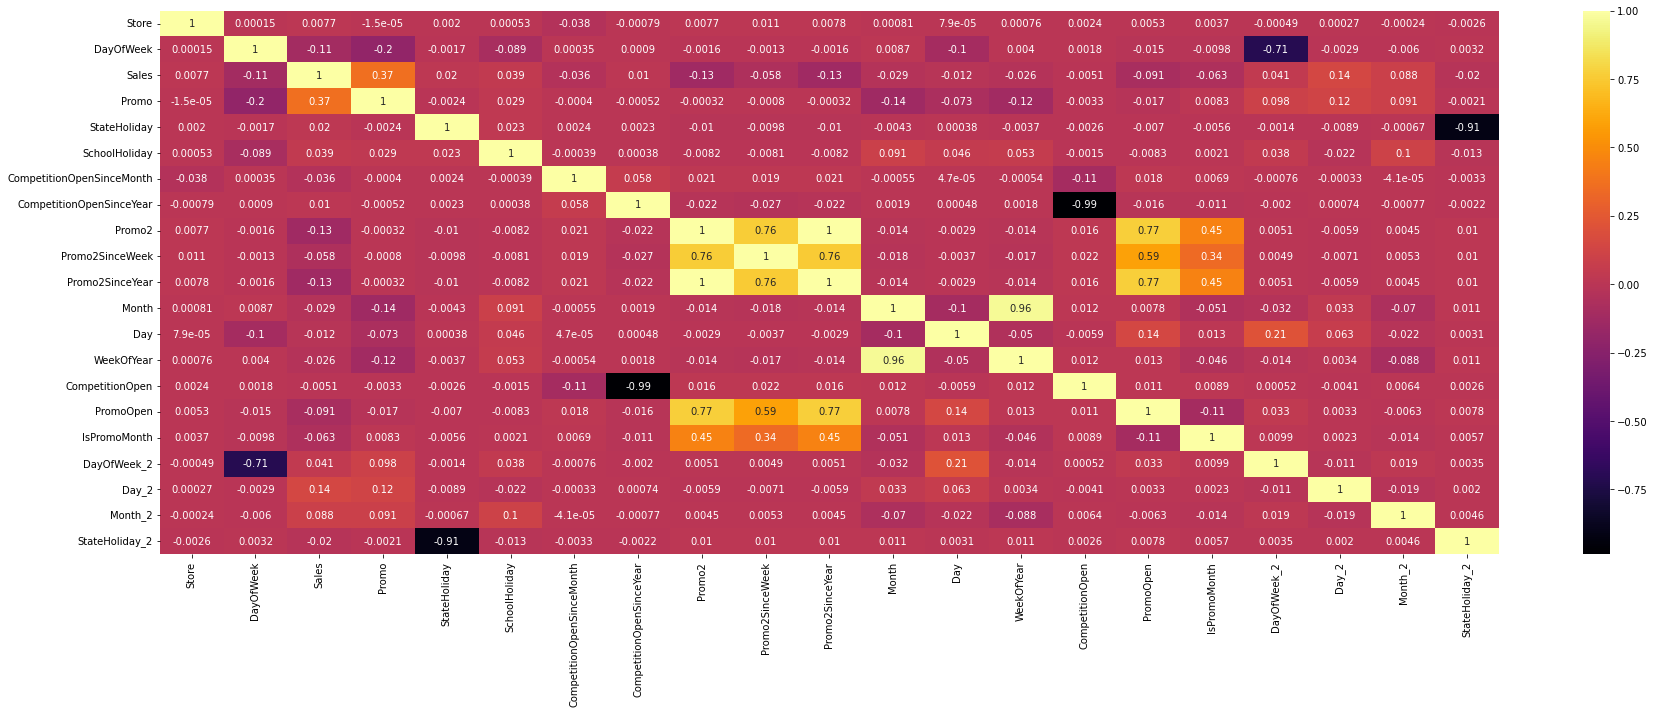

In [34]:
dfCorr = df_train.corr()
plt.figure(figsize=(30,10))
sns.heatmap(dfCorr, annot=True, cmap="inferno")
plt.show()

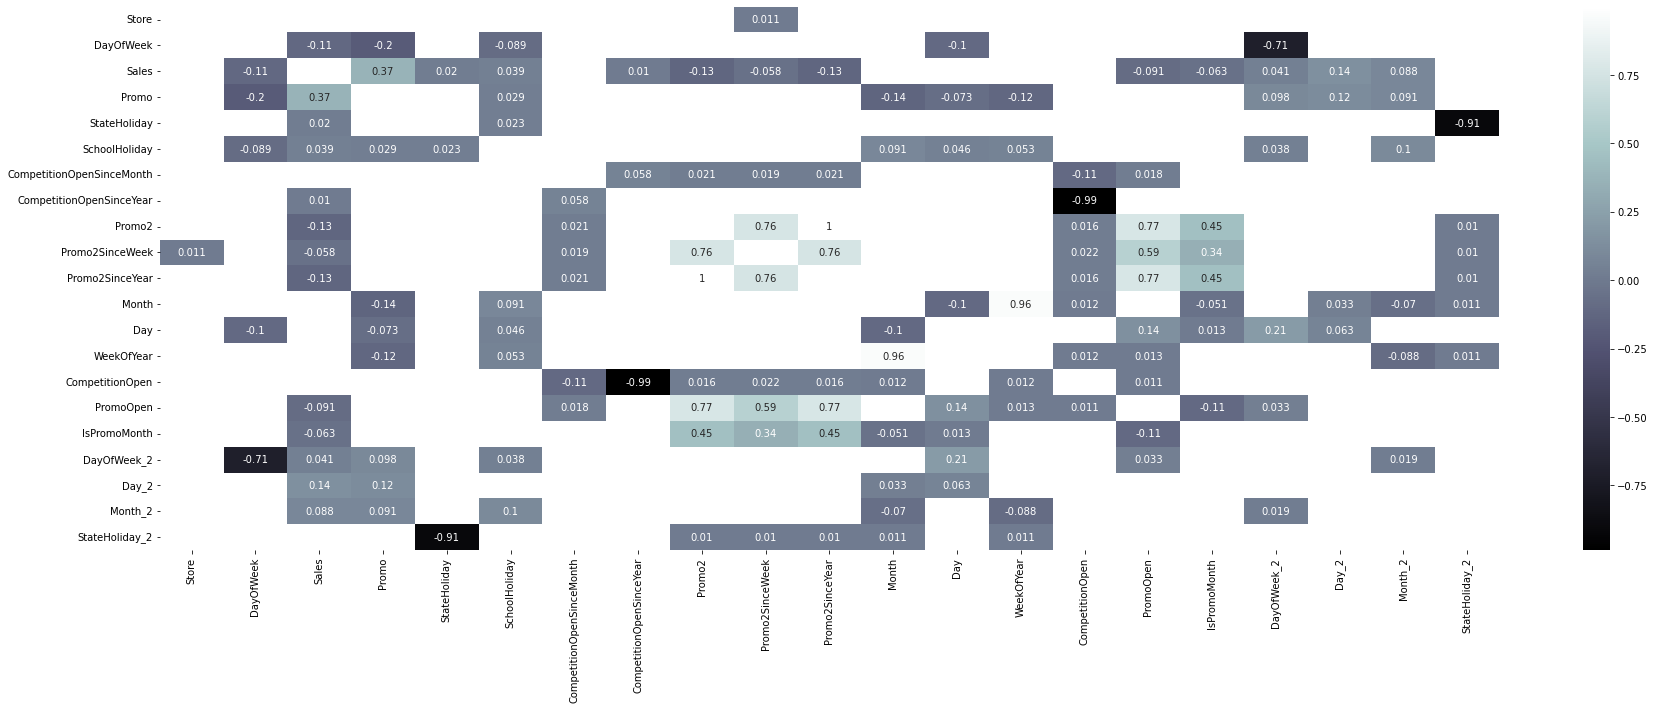

In [35]:
dfCorr = df_train.corr()
filteredDf = dfCorr[((dfCorr >= .01) | (dfCorr <= -.05)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="bone")
plt.show()

In [36]:
df_test = df_test.drop(['CompetitionOpenSinceMonth', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'StateHoliday_2'],axis=1)
df_train = df_train.drop(['CompetitionOpenSinceMonth', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'StateHoliday_2'],axis=1)

In [37]:
abs(df_train.corr()['Sales']).sort_values()

Store                       0.007723
CompetitionOpenSinceYear    0.010496
StateHoliday                0.020106
SchoolHoliday               0.038635
DayOfWeek_2                 0.041294
Promo2SinceWeek             0.058493
IsPromoMonth                0.062958
Month_2                     0.087607
PromoOpen                   0.091365
DayOfWeek                   0.111881
Promo2                      0.127556
Promo2SinceYear             0.127581
Day_2                       0.140673
Promo                       0.368199
Sales                       1.000000
Name: Sales, dtype: float64

In [38]:
df_test = df_test.drop(['CompetitionOpenSinceYear'],axis=1)
df_train = df_train.drop(['CompetitionOpenSinceYear'],axis=1)

In [39]:
df_test = df_test.drop(['Promo2SinceWeek', 'Promo2SinceYear'],axis=1)
df_train = df_train.drop(['Promo2SinceWeek', 'Promo2SinceYear'],axis=1)


In [40]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [41]:
# CategoricalCols = ['DayOfWeek', 'Day', 'Month', 'StateHoliday']

In [42]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(df_train[CategoricalCols])
# encodedCols = list(encoder.get_feature_names(CategoricalCols))

# df_train[encodedCols] = encoder.transform(df_train[CategoricalCols])
# df_train.head()

In [43]:
# df_test[encodedCols] = encoder.transform(df_test[CategoricalCols])
# df_test.head()

In [441]:
# df_test = df_test.drop(CategoricalCols,axis=1)
# df_train = df_train.drop(CategoricalCols,axis=1)

In [44]:
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from time import time

models = []
scores = []
predictions = pd.DataFrame()
forecast = pd.DataFrame()
       
test = df_train[:6*7*1115]
train = df_train[6*7*1115:]

# for i in sorted(df['Store'].unique()):
for i in range(0, 100):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 250

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)


Train a XGBoost model
[10:27:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.140733
Train a XGBoost model
[10:27:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:27:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-

100

In [45]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.15913624626734418

In [46]:
# display(forecast)
# display(df_test.loc[df_test['Store'].map(lambda x: x in range(1,101))])

In [47]:
for i in range(100, 200):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 200

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)

Train a XGBoost model
[10:27:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.102542
Train a XGBoost model
[10:27:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.173381
Train a XGBoost model
[10:27:38] WARNING: C:/buildkite-agent/builds/bu

200

In [48]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.17322511549814815

In [49]:
# display(forecast)
# display(df_test.loc[df_test['Store'].map(lambda x: x in range(101,201))])

In [50]:
for i in range(200, 300):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 250

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)

Train a XGBoost model
[10:28:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.139220
Train a XGBoost model
[10:28:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.148500
Train a XGBoost model
[10:28:11] WARNING: C:/buildkite-agent/builds/bu

In [ ]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.1713859121222138

In [ ]:
# display(forecast)
# display(df_test.loc[df_test['Store'].map(lambda x: x in range(201,301))])

In [ ]:
for i in range(300, 400):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 250

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)

Train a XGBoost model
[18:41:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.113170
Train a XGBoost model
[18:41:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.173538
Train a XGBoost model
[18:41:50] WARNING: C:/buildkite-agent/builds/bu

400

In [ ]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.1706422356838781

In [ ]:
# display(forecast)
# display(df_test.loc[df_test['Store'].map(lambda x: x in range(301,401))])

In [ ]:
for i in range(400, 500):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 250

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)

Train a XGBoost model
[18:42:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:42:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:1517: Empty dataset at worker: 0
RMSPE: 0.197441
Train a XGBoost model
[18:42:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1

500

In [ ]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.17003312725486125

In [ ]:
display(forecast)
display(df_test.loc[df_test['Store'].map(lambda x: x in range(401,501))])

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Promo2,PromoOpen,IsPromoMonth,DayOfWeek_2,Day_2,Month_2,SalesPrediction
47,1,3,0,0,1,0,0,0,5946.0,5681.0,5187.0,3970.520020
16,1,4,1,0,1,0,0,0,6431.0,5869.0,5187.0,4726.109863
15,1,0,1,0,1,0,0,0,6773.0,5869.0,6130.0,5660.250000
45,1,6,1,0,1,0,0,0,2469.0,5681.0,5807.0,5383.379883
14,1,0,1,0,1,0,0,0,6773.0,5869.0,5807.0,5912.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
18295,500,4,0,0,1,1,9,1,6431.0,5869.0,5365.0,3698.189941
18325,500,6,0,0,1,1,39,0,2469.0,5681.0,5770.0,3749.090088
18294,500,0,0,0,1,1,40,0,6773.0,5869.0,5770.0,3627.439941
18324,500,1,0,0,1,1,69,0,6973.0,5681.0,5988.0,3587.679932


,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Promo2,PromoOpen,IsPromoMonth,DayOfWeek_2,Day_2,Month_2
15791,426,3,0,0,0,0,0,0,5946.0,5681.0,5187.0
15743,425,3,0,0,0,0,0,0,5946.0,5681.0,5187.0
15695,424,3,0,0,0,1,8,1,5946.0,5681.0,5187.0
15647,422,3,0,0,0,0,0,0,5946.0,5681.0,5187.0
15599,421,3,0,0,0,1,39,0,5946.0,5681.0,5187.0
...,...,...,...,...,...,...,...,...,...,...,...
17957,491,2,0,0,0,1,9,1,6119.0,5869.0,5988.0
17909,490,2,0,0,0,1,70,0,6119.0,5869.0,5988.0
18197,498,2,0,0,0,1,70,0,6119.0,5869.0,5988.0
18293,500,2,0,0,0,1,70,0,6119.0,5869.0,5988.0


In [ ]:
for i in range(500, 600):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 250

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)

Train a XGBoost model
[18:42:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.147374
Train a XGBoost model
[18:42:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.143868
Train a XGBoost model
[18:42:54] WARNING: C:/buildkite-agent/builds/bu

600

In [ ]:
display(forecast)
display(df_test.loc[df_test['Store'].map(lambda x: x in range(501,601))])

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Promo2,PromoOpen,IsPromoMonth,DayOfWeek_2,Day_2,Month_2,SalesPrediction
47,1,3,0,0,1,0,0,0,5946.0,5681.0,5187.0,3970.520020
16,1,4,1,0,1,0,0,0,6431.0,5869.0,5187.0,4726.109863
15,1,0,1,0,1,0,0,0,6773.0,5869.0,6130.0,5660.250000
45,1,6,1,0,1,0,0,0,2469.0,5681.0,5807.0,5383.379883
14,1,0,1,0,1,0,0,0,6773.0,5869.0,5807.0,5912.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
22279,600,4,0,0,0,1,70,0,6431.0,5869.0,5365.0,5356.549805
22309,600,6,0,0,1,1,8,1,2469.0,5681.0,5770.0,5558.399902
22278,600,0,0,0,0,1,9,1,6773.0,5869.0,5770.0,5548.229980
22308,600,1,0,0,1,1,38,0,6973.0,5681.0,5988.0,5350.250000


,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Promo2,PromoOpen,IsPromoMonth,DayOfWeek_2,Day_2,Month_2
20543,553,3,0,0,0,1,8,1,5946.0,5681.0,5187.0
19583,531,3,0,0,0,0,0,0,5946.0,5681.0,5187.0
19535,530,3,0,0,0,0,0,0,5946.0,5681.0,5187.0
19487,529,3,0,0,0,0,0,0,5946.0,5681.0,5187.0
19439,528,3,0,0,0,1,8,1,5946.0,5681.0,5187.0
...,...,...,...,...,...,...,...,...,...,...,...
19925,539,2,0,0,0,1,70,0,6119.0,5869.0,5988.0
19973,540,2,0,0,0,1,70,0,6119.0,5869.0,5988.0
18389,502,2,0,0,0,1,70,0,6119.0,5869.0,5988.0
21317,574,2,0,0,0,0,0,0,6119.0,5869.0,5988.0


In [ ]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.1701615425453328

In [ ]:
for i in range(600, 700):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 250

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)

Train a XGBoost model
[18:43:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.137368
Train a XGBoost model
[18:43:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.108740
Train a XGBoost model
[18:43:26] WARNING: C:/buildkite-agent/builds/bu

700

In [ ]:
# display(forecast)
# display(df_test.loc[df_test['Store'].map(lambda x: x in range(601,701))])

In [ ]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.17026934937539678

In [ ]:
for i in range(700, 800):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 250

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)

Train a XGBoost model
[18:43:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.122637
Train a XGBoost model
[18:43:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.130403
Train a XGBoost model
[18:43:59] WARNING: C:/buildkite-agent/builds/bu

800

In [ ]:
display(forecast)
display(df_test.loc[df_test['Store'].map(lambda x: x in range(701,801))])

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Promo2,PromoOpen,IsPromoMonth,DayOfWeek_2,Day_2,Month_2,SalesPrediction
47,1,3,0,0,1,0,0,0,5946.0,5681.0,5187.0,3970.520020
16,1,4,1,0,1,0,0,0,6431.0,5869.0,5187.0,4726.109863
15,1,0,1,0,1,0,0,0,6773.0,5869.0,6130.0,5660.250000
45,1,6,1,0,1,0,0,0,2469.0,5681.0,5807.0,5383.379883
14,1,0,1,0,1,0,0,0,6773.0,5869.0,5807.0,5912.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
29623,800,4,0,0,0,0,0,0,6431.0,5869.0,5365.0,3943.360107
29653,800,6,0,0,1,0,0,0,2469.0,5681.0,5770.0,4190.299805
29622,800,0,0,0,0,0,0,0,6773.0,5869.0,5770.0,4164.080078
29652,800,1,0,0,1,0,0,0,6973.0,5681.0,5988.0,4463.850098


,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Promo2,PromoOpen,IsPromoMonth,DayOfWeek_2,Day_2,Month_2
26015,701,3,0,0,0,1,8,1,5946.0,5681.0,5187.0
26111,703,3,0,0,0,0,0,0,5946.0,5681.0,5187.0
29663,800,3,0,0,0,0,0,0,5946.0,5681.0,5187.0
29615,799,3,0,0,0,0,0,0,5946.0,5681.0,5187.0
29567,797,3,0,0,0,1,8,1,5946.0,5681.0,5187.0
...,...,...,...,...,...,...,...,...,...,...,...
28613,770,2,0,0,0,0,0,0,6119.0,5869.0,5988.0
28661,771,2,0,0,0,0,0,0,6119.0,5869.0,5988.0
26501,716,2,0,0,0,1,70,0,6119.0,5869.0,5988.0
27461,739,2,0,0,0,1,70,0,6119.0,5869.0,5988.0


In [ ]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.17034530020694377

In [ ]:
for i in range(800, 900):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 250

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)

Train a XGBoost model
[18:44:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.154855
Train a XGBoost model
[18:44:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.145505
Train a XGBoost model
[18:44:30] WARNING: C:/buildkite-agent/builds/bu

900

In [ ]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.1710088390396491

In [ ]:
for i in range(900, 1000):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 250

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)

Train a XGBoost model
[18:44:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.127323
Train a XGBoost model
[18:45:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:45:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

RMSPE: 0.133814
Train a XGBoost model
[18:45:00] WARNING: C:/buildkite-agent/builds/bu

1000

In [ ]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.17116278004433272

In [ ]:
for i in range(1000, 1115):
    test2 = test[test['Store'] == i+1]
    train2 = train[train['Store'] == i+1]

    x_train = train2.drop(['Sales'], axis=1)
    y_train = np.log1p(train2.Sales)
    x_test = test2.drop(['Sales'], axis=1)
    y_test = np.log1p(test2.Sales)
    
    x_pred = df_test[df_test['Store'] == i+1]

    dtrain = xgb.DMatrix(x_train, y_train)
    dvalid = xgb.DMatrix(x_test, y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    params = {"objective": "reg:linear",  # since it is a regression problem
              "booster": "gbtree",  # tree
              "eta": 0.03,  # learning rate   to reduce overfitting issues
              "max_depth": 10,  # depth of the tree
              "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
              "colsample_bytree": 0.7,  # subsampling of columns for each tree
              "silent": 1,  # verbosity
              "seed": 10
              }
    num_boost_round = 250

    print("Train a XGBoost model")

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=1, feval=rmspe_xg, verbose_eval=False)
    models.append(gbm)

    try:
        yhat = gbm.predict(xgb.DMatrix(x_test))
        error = rmspe(np.expm1(y_test), np.expm1(yhat))

        test2['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(yhat)]
        predictions = predictions.append(test2)

        y_pred = gbm.predict(xgb.DMatrix(x_pred))
        x_pred['SalesPrediction'] = [ round(a1, 2) for a1 in np.expm1(y_pred)]
        forecast = forecast.append(x_pred)
        print('RMSPE: {:.6f}'.format(error))
        scores.append(error)
    except Exception as e:
            # this will log the full error message and traceback
            continue

len(models)

Train a XGBoost model
[18:45:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:45:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:45:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:1517: Empty dataset at worker: 0
RMSPE: 0.148431
Train a XGBoost model
[18:45:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:45:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1

1115

In [ ]:
predictions

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,Promo2,PromoOpen,IsPromoMonth,DayOfWeek_2,Day_2,Month_2,SalesPrediction
910,1,2,5633,0,0,0,0,0,0,6119.0,5700.0,5187.0,4058.169922
882,1,3,4611,0,0,0,0,0,0,5946.0,5750.0,5187.0,4117.350098
790,1,6,5693,0,0,0,0,0,0,2469.0,5875.0,5187.0,4688.959961
760,1,0,5614,1,0,0,0,0,0,6773.0,5932.0,5187.0,4870.310059
729,1,1,4994,1,0,1,0,0,0,6973.0,5681.0,5187.0,4794.779785
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017162,1115,5,5361,0,0,0,1,78,0,5649.0,6378.0,6130.0,5041.939941
1017160,1115,0,7580,1,0,0,1,80,0,6773.0,6370.0,6130.0,6064.310059
1017159,1115,1,4882,1,0,0,1,81,0,6973.0,5826.0,6130.0,5598.169922
1017158,1115,2,6169,1,0,0,1,82,0,6119.0,5839.0,6130.0,5600.620117


In [ ]:
rmspe(predictions['Sales'], predictions['SalesPrediction'])

0.17047883411291348

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
sqrt(mean_squared_error(predictions['Sales'], predictions['SalesPrediction'])) 

1331.4372120033804

In [ ]:
y_pred_fin = []
for i in df_test.index:
    s_id = df_test.loc[i]['Store'].astype('int')
    y_pred_fin.append(models[s_id-1].predict(xgb.DMatrix(df_test.loc[[i]]))[0])

In [ ]:
df_test['Prediction'] = np.expm1(y_pred_fin)
display(df_test)

In [ ]:
forecast

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Promo2,PromoOpen,IsPromoMonth,DayOfWeek_2,Day_2,Month_2,SalesPrediction
47,1,3,0,0,1,0,0,0,5946.0,5681.0,5187.0,3970.520020
16,1,4,1,0,1,0,0,0,6431.0,5869.0,5187.0,4726.109863
15,1,0,1,0,1,0,0,0,6773.0,5869.0,6130.0,5660.250000
45,1,6,1,0,1,0,0,0,2469.0,5681.0,5807.0,5383.379883
14,1,0,1,0,1,0,0,0,6773.0,5869.0,5807.0,5912.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
41047,1115,4,0,0,0,1,39,0,6431.0,5869.0,5365.0,4418.839844
41077,1115,6,0,0,1,1,69,0,2469.0,5681.0,5770.0,4579.240234
41046,1115,0,0,0,0,1,70,0,6773.0,5869.0,5770.0,4226.549805
41076,1115,1,0,0,1,1,8,1,6973.0,5681.0,5988.0,4135.790039


In [476]:
# # main_list = list(set(df_test.index) - set(forecast.index))
# # main_list

In [477]:
# # df_test.loc[main_list]

weight correction
RMSPE for 0.999:0.170625
RMSPE for 1.000:0.170479
RMSPE for 1.001:0.170338
RMSPE for 1.002:0.170202
RMSPE for 1.003:0.170071
RMSPE for 1.004:0.169946
RMSPE for 1.005:0.169826
RMSPE for 1.006:0.169712
RMSPE for 1.007:0.169603
RMSPE for 1.008:0.169499
RMSPE for 1.009:0.169401
RMSPE for 1.010:0.169308
RMSPE for 1.011:0.169220
RMSPE for 1.012:0.169138
RMSPE for 1.013:0.169061
RMSPE for 1.014:0.168990
RMSPE for 1.015:0.168924
RMSPE for 1.016:0.168864
RMSPE for 1.017:0.168809
RMSPE for 1.018:0.168759
RMSPE for 1.019:0.168715
RMSPE for 1.020:0.168676
RMSPE for 1.021:0.168643
RMSPE for 1.022:0.168615
RMSPE for 1.023:0.168593
RMSPE for 1.024:0.168576
RMSPE for 1.025:0.168565
RMSPE for 1.026:0.168559
RMSPE for 1.027:0.168558
RMSPE for 1.028:0.168563
RMSPE for 1.029:0.168574
RMSPE for 1.030:0.168590
RMSPE for 1.031:0.168611
RMSPE for 1.032:0.168638
RMSPE for 1.033:0.168670
RMSPE for 1.034:0.168708
RMSPE for 1.035:0.168752
RMSPE for 1.036:0.168800
RMSPE for 1.037:0.168854
RMSPE f

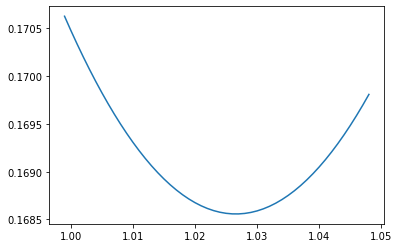

In [ ]:
print("weight correction")
W=[(0.999+(i/1000)) for i in range(50)]
S =[]
for w in W:
    error = rmspe(predictions['Sales'], predictions['SalesPrediction']*w)
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [ ]:
col_1 = ['Sales','SalesPrediction']

# correction by store
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(predictions[predictions['Store']==i+1],columns = col_1)
    # s2 = pd.DataFrame(df_test[df_test['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(s1.Sales, s1.SalesPrediction*w)
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    # b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    # W_test.extend(b_test.tolist())

In [ ]:
yhat_new = predictions['SalesPrediction']*W_ho
error = rmspe(predictions['Sales'], yhat_new)
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.169094


In [ ]:
df_test

In [ ]:
df_test['NewPrediction'] = df_test['Prediction']*W_test

In [ ]:
df_test

In [ ]:
scores

[0.1407325668882059,
 0.17205774308158062,
 0.1358718657672399,
 0.10548959677394376,
 0.24653920458206402,
 0.2583343223681279,
 0.16400604397445145,
 0.1760672315380835,
 0.1830671541991424,
 0.08989307601451281,
 0.12474288744969392,
 0.1101748727221795,
 0.16313499685795865,
 0.13485335176599522,
 0.12143046407346768,
 0.12837763529644258,
 0.20264030830331725,
 0.13757946974862517,
 0.12120273034528109,
 0.14161180734035633,
 0.1590999440447855,
 0.11136874469199007,
 0.1398860039791348,
 0.11562604310296315,
 0.18020442298806397,
 0.1909993667912356,
 0.12005313730876854,
 0.2122150207971733,
 0.141148558836488,
 0.20707580754142008,
 0.1193119192620282,
 0.1531881127478176,
 0.1353099833395038,
 0.07828550913407376,
 0.14665676113990828,
 0.10300296089625588,
 0.17961123190503936,
 0.1736215855660153,
 0.1590674415752275,
 0.15160965514601565,
 0.21189773946237703,
 0.12101933288275933,
 0.12357104021023861,
 0.12268310511928794,
 0.175798492025353,
 0.15372717379191211,
 0.1118

In [ ]:
import pandas as pd
from sklearn import linear_model

x_train = train.drop(['Sales'], axis=1)
y_train = np.log1p(train.Sales)
x_test = test.drop(['Sales'], axis=1)
y_test = np.log1p(test.Sales)

ols = linear_model.LinearRegression()
model = ols.fit(x_train, y_train)

yhat = model.predict(x_test)

In [ ]:
yhat2 = np.expm1(yhat)
yhat2

array([5344.65736565, 4705.59485579, 5585.99214316, ..., 7501.48048298,
       6650.83954892, 7478.73190908])

In [ ]:
error = rmspe(np.expm1(y_test), np.expm1(yhat))
print("RMSPE with linear regression:", error)

RMSPE with linear regression: 0.4981081073591792


In [489]:
# x_train = train.drop(['Sales'], axis=1)
# y_train = np.log1p(train.Sales)
# x_test = test.drop(['Sales'], axis=1)
# y_test = np.log1p(test.Sales)

# dtrain = xgb.DMatrix(x_train, y_train)
# dvalid = xgb.DMatrix(x_test, y_test)
# watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

# params = {"objective": "reg:linear",  # since it is a regression problem
#           "booster": "gbtree",  # tree
#           "eta": 0.03,  # learning rate   to reduce overfitting issues
#           "max_depth": 10,  # depth of the tree
#           "subsample": 0.9,  # subsample the data prior to growing trees - overcomes overfitting
#           "colsample_bytree": 0.7,  # subsampling of columns for each tree
#               "silent": 1,  # verbosity
#               "seed": 10
#           }
# num_boost_round = 250

# print("Train a XGBoost model")

# gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
#                   early_stopping_rounds=10, feval=rmspe_xg, verbose_eval=True)

# yhat = gbm.predict(xgb.DMatrix(x_test))
# error = rmspe(np.expm1(y_test), np.expm1(yhat))


Train a XGBoost model
[19:02:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:02:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:8.02422	train-rmspe:0.99981	eval-rmse:7.96894	eval-rmspe:0.99980
[1]	train-rmse:7.78405	train-rmspe:0.99971	eval-rmse:7.72968	eval-rmspe:0.99969
[2]	train-rmse:7.55118	train-rmspe:0.99959	eval-rmse:7.49715	eval-rmspe:0.99957
[3]	train-rmse:7.32532	train-rmspe:0.99944	eval-rmse:7.27146	eval-rmspe:0.99941
[4]	train-rmse:7.10616	train-rmspe:0.99926	eval-rmse:7.05330	eval-rmspe:0.99922
[5]	train-rmse:6.89359	train-rmspe:0.99905	eval-rmse:6.84174	eval-rmspe:0.99899
[6]	train-rmse:6.68742	train-rmspe:0.99879	eval-rmse:6.63643	eval-rmspe